# <span style="color:#CCE8FF; background-color:#111111">병원 개/폐업 예측 프로젝트</span>
<!-- <img src="../data/수술.jpg" width="900px" height="450px" title="배경"></img><br/> -->

<!-- ###### 출처 : <http://premium.chosun.com/site/data/html_dir/2014/01/13/2014011303299.html> -->

## <span style="color:#EEEEEE; background-color:#111111">1. 기획</span>

<img src="../data/병원현황1.png" width="600px" height="200px" title="현황1"></img><br/>
<img src="../data/병원현황2.png" width="600px" height="120px" title="현황2"></img><br/>
<img src="../data/병원현황3.png" width="600px" height="120px" title="현황3"></img><br/>


대한민국의 의료 체계가 심상치 않습니다.  
  
외과, 산부인과, 소아청소년과의 지원율은 갈수록 줄어들고 
 
피부과, 성형외과, 안과의 지원율은 갈수록 오르고 있습니다.  
  
<br>
    
지역별로 의료 복지의 수준 차이도 많이 납니다.  
  
2023년 1분기 기준으로 상급 종합병원, 종합병원, 병원, 의원, 한방병원의 총 합계가  
  
서울은 **9,912**개, 경기도는 **8,413**개 입니다.  
  
울산의 경우 **675**개, 제주 **499**개, 강원도는 **850**개 입니다. 
  
서울과 제주는 **약 20배** 차이가 나네요😱  
  
물론 지역의 인구 밀도나 1인당 의료 기관 수 등을 살펴봐야 하지만  
  
절대적인 수치로도 꽤 큰 차이가 나는 것을 알 수 있습니다.  
  
<br>
  

그리고 얼마 없는 병원 마저 폐업의 위기에 있습니다.  
<br>
환자 수가 줄어들어 매출이 떨어지든, 병원 운영에 필요한 자금을 대출받지 못 하든, 자금 운용을 잘못하든지 같은 이유로 말이죠.  
<br>
현재 운영 중인 병원도 없어져 치료를 받지 못 한다면 국민의 대다수가 불행을 피하지 못 할 것입니다.😭 
<br>
  


만약, 병원이 폐업하게 되는 것을 예측할 수 있다면, 다른 대안을 생각할 수도 있지 않을까요?
   
병원이 폐업을 하기 전 어떤 특징을 보이는지 아래 프로젝트를 통해 예측해보고자 합니다. 
<br>
  
  
***
*이번 프로젝트를 통해서 기대할 수 있는 효과는*  
1. 폐업 위기 예측을 통해, 병원 사업 구조 개선  
  
2. 대출 혹은 투자 등에 대한 금융 기회 제공  
  
입니다.  
  
1번 효과의 경우 **병원 경영진과 환자들**에게,  
  
2번 효과의 경우 **투자자**에게 긍정적인 경험을 줄 것입니다.  
  
<br>


***
사용할 데이터의 경우
* 병원 운영 + 재무 정보(DACON에서 제공)  
  
    - train.csv
    - test.csv  
<br>
* 시군구별 인구수  
  
    - 행정구역_시군구_별__성별_인구수_20230718231833.csv
  
위와 같이 사용합니다.  
  
첫 번째 데이터는 병원 운영과 직접적인 관련이 있어 예측이 용이할 것이고,  
  
두 번째 데이터는 결측치를 채우기 위해 사용할 것 입니다.  
  
<br>
이번 프로젝트를 통해서  
  
병원 데이터를 분석하고 Binary Classification할 수 있는 모델을 생성해내어,  
  
<span style="color:#33CC33">병원의 개/폐업 여부</span>를 예측해 보겠습니다👩‍💻

## <span style="color:#EEEEEE; background-color:#111111">2. 데이터 전처리</span>

데이터를 불러오기 전  
  
*패키지*( 또는 *라이브러리*)에 대해서 알아볼까요?  
  
<br>

**패키지(또는 라이브러리)** 란 어떤 목적을 가지고 작동하는 프로그램인 '모듈'을 묶어 놓은 것입니다.  
  
패키지는 파일이 포함된 디렉토리(폴더)로 구성돼 있습니다.  
  
그리고 다른 사람이 만든 프로그램을 불러와서 사용하는 것을 '라이브러리'라고 부릅니다.  
  
<br>

만약 데이터 분석을 하다가 통계식을 사용하고 싶을 때  
  
직접 함수를 만들고 통계식 계산을 할 수 있게 스크립트를 짤 수 있지만,  
  
다른 사람이 만들어 놓은 라이브러리를 다운로드 받아 사용할 수 있습니다.  
  
내가 직접 구현했어야 했던 것을 직접 사용하니 편하고 시간이 절약되겠죠?
  
<br>
다운로드 받은 라이브러리(혹은 패키지, 모듈)를 현재 작성하고 있는 파일에 불러오는 것을  
  
'**import**'한다고 합니다. 
  
실제로 불러올 때는  
  
<span style="color:#33CC33">import</span> <b>'모듈명'</b>  
  
혹은  
  
<span style="color:#FF0000">from</span> <b>'라이브러리명'</b> <span style="color:#33CC33">import</span> <b>'모듈명'</b>  
  
으로 불러오면 되겠습니다.  
  
<br>
아래와 같이

In [264]:
import math

수학과 관련된 모듈을 가지고 있는 **'math'** 라이브러리를 불러올 수도 있습니다.

프로젝트에 사용한 라이브러리는 다음과 같이 모아 놓겠습니다↓    
    
프로젝트 진행 도중 사용되는 라이브러리들을 한번에 실행시켜 놓는 장점이 있기 때문입니다🫡  
  
물론 코드를 설명하는 과정에서도 import 하는 것을 보여드릴게요^^  
  
이러한 라이브러리를 사용하는구나~ 라고 봐주시면 됩니다!

In [104]:
# 이번 프로젝트에서 사용될 패키지(라이브러리) 모음집

import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, f1_score, silhouette_samples, silhouette_score, roc_curve
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import sklearn
import statsmodels
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy
import requests
import pprint
import xgboost
import scipy
import warnings
import re
import joblib
import keras
from datetime import datetime
from scipy import stats
# from urllib import parse
# from bs4 import BeautifulSoup

아래 코드는 프로젝트를 진행할 때 편의를 위해 미리 작성해 놓은 코드입니다.  

1. 첫 번째 코드는 pandas 라이브러리(보통 pd라고 씀)를 사용할 때 나오는 숫자들이 너무 크면 지수 형태로 표현될 수 있으므로, 실수 형태로 표현하기 위함입니다.  ex) 1e^10  >>> 10000000000  
  
2. 두 번째 코드는 상위 폴더의 상대 경로를 저장해 놨습니다. 변수명이 왠지 상위 폴더와 관계 없는 것 같은 이유는 중간에 경로가 한 번 수정됐기 때문입니다.  
  
3. 세 번째 코드는 코드를 실행했을 때 나오는 경고 문구를 무시하겠다는 의미입니다. 경고 문구 때문에 출력되는 부분이 길어지면 불편한 부분이 있기 때문입니다.

In [2]:
# 지수 형태의 실수를 소수점 3자리까지 표기
pd.options.display.float_format = "{:.3f}".format

# 상위 폴더 경로
dirShare = ".."

# 경고 출력 무시
warnings.filterwarnings("ignore")

그리고 팀 단위로 프로젝트를 수행할 때 중요한 점은 역시 사용하는 작업 환경의 버전을 통일해 놔야 하는 것입니다!  
  
작업 환경의 버전이 다르면, 코드가 실행이 안 되는 경우가 있기 때문입니다. 아래와 같이 중요 라이브러리의 버전을 확인해 봅시다. 

#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [267]:
# print("라이브러리명".__version__)

예시 코드를 보고 버전 확인을 해 보셨나요?  
  
저희는 아래와 같이 여러 라이브러리의 버전을 확인하고 팀원들과 버전을 통일했습니다!

In [3]:
# 라이브러리 버전 확인
print("Python 현재 버전 : " + sys.version)
print("pandas 현재 버전 : " + pd.__version__)
print("Numpy 현재 버전 : " + np.__version__)
print("scikit-learn 현재 버전 : " + sklearn.__version__)
print("scipy 현재 버전 : "+ scipy.__version__)
print("statsmodels 현재 버전 : " + statsmodels.__version__)
print("xgboost 현재 버전 : " + xgboost.__version__)
print("keras 현재 버전 : " + keras.__version__)

Python 현재 버전 : 3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]
pandas 현재 버전 : 2.0.3
Numpy 현재 버전 : 1.24.3
scikit-learn 현재 버전 : 1.3.0
scipy 현재 버전 : 1.11.1
statsmodels 현재 버전 : 0.14.0
xgboost 현재 버전 : 1.7.6
keras 현재 버전 : 2.13.1


버전 통일이 완료됐다면 지금부터 데이터 전처리 작업에 들어가 보겠습니다👍👍

### <span style="color:#ffffff; background-color:#111111">기본전처리</span>

데이터를 분석하기 전, 전처리를 할 때  
  
우리는 보통 '**데이터 프레임(Dataframe)**' 형태로 작업을 하게 됩니다.  
  
<br>
데이터 프레임이란 뭘까요?  
  
***
<img src="../data/데이터프레임.png" width="600px" height="450px" title="데이터 프레임"></img><br/>
<span style="color:#EEEEEE; font-size: 0.5em">출처 : https://link2me.tistory.com/2104</span>

데이터 프레임은 데이터를 2차원 형태로 표현한 것입니다.  
  
관계형 데이터 베이스나 엑셀의 테이블(table)과 동일한 형태죠.  

<br>
데이터 프레임에서 중요한 요소는 세가지 입니다.  
  
* 열(column)  
  
* 행(row)  

* 인덱스(index)  
  
입니다.  
***
'열(column)'은 데이터 프레임에서 세로줄입니다.  
  
또한 열의 이름은 데이터의 속성을 나타냅니다.  
  
예를 들어 '홍길동'이라는 사람의 데이터를 저장한다면 아래와 같이 저장할 수 있습니다.  
  
***'홍길동', 25세, 남자***  
  
여기서 홍길동은 '이름'이라는 열로, 25세는 '나이'라는 열로, 남자는 '성별'이라는 열로 정리할 수 있습니다.
***
'행(row)'은 데이터 프레임에서 가로줄입니다.  
  
열에 해당하는 속성을 가진 다른 데이터들을, 보통 위에서 아래로 입력하게 됩니다.  
  
아까 위에서 홍길동이라는 사람에 대한 정보가 어느 사이트의 회원 가입 정보라고 합시다.  
  
거기에 '나이팅게일'이라는 사람이 회원가입했다고 합시다.  
  
<br>
그럼 아래와 같이  
  
***'홍길동', 25세, 남자***  
  
***'나이팅게일', 29세, 여자***  
  
데이터가 입력이 됩니다.  
  
<br>
홍길동이라는 회원 정보 밑에 나이팅게일이라는 새로운 데이터가 입력됐고,  
  
두 회원은 '이름', '나이', '성별'이라는 속성을 열에 입력합니다.  
  
<br>
새로운 회원이 들어오면 나이팅게일 밑에 3가지 속성을 가지고 입력될 것입니다.
***
'인덱스(index)'는 데이터의 위치를 알려줍니다.  
  
홍길동이 회원 가입했을 때 '0'의 인덱스를 붙여주고,  
  
나이팅게일이 회원 가입했을 때 '1'의 인덱스를 붙여주고, 
  
데이콘이 회원 가입했을 때는 '2'의 인덱스를 붙여줍니다.  
  
<br>
이렇게 인덱스를 붙여 놓으면 ***'아 데이콘은 인덱스 번호 2 위치에 있구나!'*** 라고 생각할 수 있죠.  
  
<br>
처음 인덱스를 0으로 붙인 이유는 인덱스가 보통 0부터 시작하기 때문입니다.  
  
컴퓨터와 관련돼 있는 대부분의 개념은  
  
숫자의 첫 시작이 1이 아니라, 0부터 시작한다고 생각하시면 편합니다.
***
열, 행, 인덱스의 개념은 중요합니다.  
  
데이터를 검색하고, 합치고, 없애고 할 때  
  
위 3가지 기준으로 이뤄지기 때문입니다.  
  
<br>
이제부터 데이터를 데이터 프레임 형태로 다루면서 전처리를 진행해 보도록 할게요~

***
먼저 pandas 라이브러리를 import 합시다.

**pandas** 라이브러리는 데이터 프레임이나 시리즈(series) 형태로 데이터를 전처리할 수 있는 기능을 제공합니다.  

pandas의 함수나 메서드가 어떻게 작동하는지 궁금할 때는  
  
공식 홈페이지의 Documentation을 이용하는 것이 가장 좋습니다!  

주소는 아래와 같습니다.  

https://pandas.pydata.org/docs/index.html  
  
pandas import는 아래와 같이 입력합니다.

In [269]:
import pandas as pd

pandas 뒤에 붙은 as는 'alias'로 별명이라는 뜻입니다.  
  
불러온 모듈이 길거나 할 때, 별명을 설정해 짧게 부르도록 하는 것입니다.  
  
보통 pandas의 별명을 **'pd'** 로 하는데, 이는 pandas 라이브러리 사용자들의 암묵적인 규칙입니다.  
  
다른 별명을 사용해도 상관은 없지만  
  
다른 사람이 내 코드를 볼 때나, 혹은 내가 다른 사람 코드를 볼 때  
  
pd를 보고 pandas라는 것을 바로 아는 것이 더 효율적이기 때문에  
  
pd라고 쓰는 것이 좋겠죠?  
***
pandas를 이용해 train.csv를 불러와 봅시다.  
  
예시 코드는 아래와 같습니다.

#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [4]:
# train.csv 데이터 프레임으로 불러오기
df = pd.read_csv(dirShare+"/data/train.csv")

# # df 정보 확인
df.info()

# # df 상위 10개 불러오기
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,same
1,3,open,gyeongnam,32,19970401,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,same
2,4,open,gyeonggi,89,20161228,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,same
3,7,open,incheon,141,20000814,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,same
4,9,open,gyeongnam,32,20050901,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,same
5,11,open,gyeongnam,155,20020501,243.000,general_hospital,33580536703.000,9222996930.000,23727912054.000,...,0.000,21861133888.000,17087136895.000,20000000.000,0.000,0.000,5879003604.000,397.000,390.000,same
6,14,open,gyeonggi,169,19820702,213.000,general_hospital,22552179836.000,4449958166.000,16573328452.000,...,19642026834.000,13292026834.000,12155602473.000,6350000000.000,6230000000.000,18888294786.000,9174282922.000,221.000,246.000,same
7,15,open,busan,66,19871102,250.000,general_hospital,64359169160.000,20758010719.000,40882537264.000,...,35984818131.000,11219645317.000,0.000,24765172814.000,16000000000.000,14217864484.000,9177282701.000,489.000,489.000,same
8,16,open,jeonnam,91,20060922,280.000,nursing_hospital,12748392940.000,328697683.000,11076189315.000,...,0.000,13113246330.000,12664417803.000,41962676.000,0.000,0.000,0.000,243.000,243.000,same
9,17,open,seoul,4,20000124,55.000,general_hospital,41406077905.000,6624671265.000,35120182720.000,...,34906729636.000,19675893406.000,16365396427.000,15230836230.000,3400000000.000,20244525873.000,9554580715.000,370.000,382.000,same


예시 코드에서 사용된 메서드에 대해 간단하게 살펴 봅시다🤔  
  
* .read_csv() : .csv 파일을 데이터 프레임 형태로 불러옵니다. 파일에 따라 'encoding=' 파라미터에 encoding 방식을 입력해줘야 하는 경우가 있습니다.  
  
* .info() : 불러온 데이터 프레임의 각종 정보를 보여줍니다. 데이터 총 개수, 컬럼의 총 개수, 컬럼명, 컬럼 타입, 컬럼의 null아닌 데이터 개수 등을 확인할 수 있습니다.  
  
* .head() : 데이터 프레임의 상위 n개의 데이터를 출력합니다. 기본적으로 5개를 출력하며, 파라미터 값으로 자연수를 입력할 수 있습니다. 위 예시의 경우 10을 입력해 상위 10개를 확인합니다.  
  
한번 퀴즈를 내볼까요?  
  
우리가 가진 데이터 중 test.csv를 데이터 프레임으로 불러오고, 데이터 프레임의 정보와 상위 5개의 정보를 뽑아봅시다.  
  
(퀴즈인 부분은 직접 해 보시기 바랍니다.)

#### <span style="color:#99FFFF; background-color:#111111">퀴즈 1</span> 

In [271]:
# test.csv 데이터 프레임으로 불러오기

# 데이터 프레임 정보 확인하기

# 상위 5개의 정보 뽑기

저희는 아래와 같이 작성했습니다↓

In [5]:
df_t = pd.read_csv(dirShare+"/data/test.csv")

df_t.info()
df_t.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             127 non-null    int64  
 1   OC                  0 non-null      float64
 2   sido                127 non-null    object 
 3   sgg                 127 non-null    int64  
 4   openDate            126 non-null    float64
 5   bedCount            119 non-null    float64
 6   instkind            125 non-null    object 
 7   revenue1            125 non-null    float64
 8   salescost1          125 non-null    float64
 9   sga1                125 non-null    float64
 10  salary1             125 non-null    float64
 11  noi1                125 non-null    float64
 12  noe1                125 non-null    float64
 13  interest1           125 non-null    float64
 14  ctax1               125 non-null    float64
 15  profit1             125 non-null    float64
 16  liquidAs

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,NaN,incheon,139,19981125.000,300.000,general_hospital,66824864410.000,0.000,65657092101.000,...,55406431667.000,50684431667.000,37143344381.000,4720000000.000,4690000000.000,16085395374.000,8944587276.000,693,693,same
1,5,NaN,jeju,149,20160309.000,44.000,hospital,34957575568.000,0.000,32592697196.000,...,67308375170.000,42098280733.000,24200000000.000,25210094437.000,18300000000.000,3789134965.000,0.000,379,371,same
2,6,NaN,jeonnam,103,19890427.000,276.000,general_hospital,23260305967.000,2542570943.000,23087485220.000,...,0.000,27775892339.000,21822782890.000,0.000,0.000,0.000,16385400958.000,NaN,NaN,NaN
3,8,NaN,busan,71,20100226.000,363.000,general_hospital,0.000,0.000,0.000,...,12115167523.000,9556237015.000,4251867179.000,2558930508.000,0.000,39142835592.000,0.000,760,760,same
4,10,NaN,jeonbuk,26,20040604.000,213.000,general_hospital,50370249897.000,0.000,48558027276.000,...,43959732611.000,7535567468.000,3298427375.000,36424165143.000,21347120000.000,25744878066.000,15072685841.000,437,385,same


***
train.csv와 test.csv의 전체 데이터 개수를 살펴 봅시다.

아래와 같이  
  
**.shape()** 메서드를 사용하면 데이터 프레임의 모양이 (행의 개수, 열의 개수)형태인 튜플로 반환됩니다.  
  
행 개수를 알면 되니 .shape[0] 을 입력해 첫 번째 값을 확인합니다

In [6]:
# 데이터 개수 확인하기
print("train 데이터 개수 : ", df.shape[0])
print("test 데이터 개수 : ", df_t.shape[0])

# len(df)를 써도 동일

train 데이터 개수 :  301
test 데이터 개수 :  127


len 함수를 써도 동일하게 확인할 수 있습니다.  
  
한 번 **len()** 함수를 써서 확인해 봅시다.
#### <span style="color:#99FFFF; background-color:#111111">퀴즈 2</span> 

In [274]:
# len을 써서 train.csv 데이터 개수를 확인합시다.

아래와 같이 확인할 수 있습니다↓

In [7]:
print("train 데이터 개수 : ", len(df))

train 데이터 개수 :  301


***
데이터 프레임의 있는 숫자 정보를 통해 여러 통계 정보를 알려주는 메서드가 있습니다.  
  
바로 *.decribe()* 인데요.  
  
데이터 개수, 평균, 표준편차, 최소값, 사분위수, 최대값 등을 한 눈에 확인할 수 있기에  
  
데이터의 통계치를 개략적으로 확인할 수 있습니다.  
  
train.csv로 만든 데이터 프레임의 통계치를 확인해 볼까요.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [8]:
# 숫자 형식의 컬럼의 기술통계값을 출력, train.csv
df.describe()

,inst_id,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2
count,301.000,301.000,301.000,296.000,293.000,293.000,293.000,293.000,293.000,293.000,...,293.000,293.000,293.000,293.000,293.000,293.000,293.000,293.000,291.000,288.000
mean,219.056,81.040,20050125.801,145.709,12881747447.993,2014902794.594,10332439064.089,5654114566.904,269615124.573,511587022.570,...,222670.000,8146026488.788,3860583593.406,1510050431.986,4471247363.877,2709978815.423,5273919018.089,978627865.256,142.546,134.326
std,121.235,50.970,88938.154,118.924,20435433475.616,7460270656.568,14938862491.946,8083342530.256,802370115.514,1060379255.452,...,3811496.447,12557995349.365,6797242094.076,2953412250.368,7659580436.397,4564001070.999,10812593821.248,4688797890.975,160.191,151.062
min,1.000,1.000,19780124.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-20147802018.000,-2781506722.000,0.000,0.000
25%,112.000,37.000,20011017.000,52.750,3252111902.000,0.000,2758200772.000,1626052720.000,8217133.000,80133952.000,...,0.000,1283220350.000,285574118.000,0.000,25578782.000,0.000,1017572570.000,0.000,53.500,53.750
50%,230.000,75.000,20071126.000,136.500,5524218104.000,210410492.000,4684074465.000,2659892367.000,43637641.000,183196506.000,...,0.000,3784552900.000,1454049945.000,85425488.000,1969746813.000,1100000000.000,2894969804.000,0.000,80.000,79.000
75%,321.000,123.000,20111021.000,193.000,12748392940.000,910527771.000,10778762060.000,6363400069.000,205033071.000,420333030.000,...,0.000,8465053127.000,4364713622.000,1567966980.000,4905441439.000,3360000000.000,5370284792.000,101444685.000,181.500,170.000
max,428.000,178.000,20170607.000,656.000,151000000000.000,98503322990.000,103000000000.000,64035593950.000,9144170639.000,8686379500.000,...,65242310.000,85088583901.000,68468775764.000,17593752360.000,51503883627.000,32561472110.000,125000000000.000,68527297093.000,1200.000,1200.000


퀴즈로 test.csv의 통계치를 확인해 봅시다.  
  
#### <span style="color:#99FFFF; background-color:#111111">퀴즈 3</span> 

In [277]:
# 숫자 형식의 컬럼의 기술통계값을 출력, test.csv

아래와 같이 확인해 볼 수 있습니다↓

In [9]:
# 숫자 형식의 컬럼의 기술통계값을 출력, test.csv
df_t.describe()

,inst_id,OC,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,...,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2
count,127.000,0.000,127.000,126.000,119.000,125.000,125.000,125.000,125.000,125.000,...,125.000,125.000,125.000,125.000,125.000,125.000,125.000,125.000,125.000,125.000
mean,205.906,NaN,95.858,20050851.333,172.790,18244463620.632,3973320516.568,13404099537.944,7415083961.448,517551263.832,...,13362088426.024,351383068.584,19731.144,11898512213.344,5633432084.136,2181713388.144,6495025895.904,4482682424.408,6116178748.752,1648473877.648
std,131.802,NaN,52.684,87958.149,126.024,31335295156.854,14199483023.803,20544811391.822,12100434017.387,1193138608.474,...,20854039250.721,979109688.084,220600.896,19711820111.028,9662047510.141,4952448637.736,12036733189.767,7517020054.736,9813461143.417,4779443752.861
min,2.000,NaN,6.000,19760409.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-2955957091.000,-8600000000.000
25%,89.000,NaN,51.000,20000826.000,94.000,3235888530.000,0.000,3083860292.000,1666742310.000,16410940.000,...,2807762809.000,0.000,0.000,1679896491.000,391415567.000,0.000,132136760.000,0.000,949265633.000,0.000
50%,199.000,NaN,95.000,20071066.000,156.000,6637115540.000,189692304.000,5716501623.000,3263054070.000,53191709.000,...,5450482767.000,33173766.000,0.000,4494217146.000,1554505639.000,300000000.000,2030000000.000,1750000000.000,2427138957.000,0.000
75%,328.000,NaN,144.500,20117895.500,213.000,17040391156.000,1192329214.000,14452425786.000,7198103374.000,371459225.000,...,11871143997.000,204899800.000,0.000,14120305387.000,6586241453.000,2650000000.000,5700000000.000,4857047850.000,5881964991.000,693516549.000
max,431.000,NaN,177.000,20170531.000,771.000,181000000000.000,116000000000.000,127000000000.000,82395611833.000,7302719335.000,...,113000000000.000,7112779552.000,2466393.000,131000000000.000,52414267533.000,37143344381.000,78556538604.000,36202877976.000,49244922328.000,25617866194.000


***
컬럼별 null의 갯수를 확인해 볼까요?  
  
<br>
데이터 프레임의 모양을 확인했던 **.shape**와  
  
각 컬럼에서 null이 아닌 값을 세는 **.count()** 를 사용하면 됩니다.  
  
<br>
예시 코드는 아래와 같습니다.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [10]:
# 컬럼별 null 개수 확인하기, train.csv
df.shape[0] - df.count()

inst_id                0
OC                     0
sido                   0
sgg                    0
openDate               0
bedCount               5
instkind               1
revenue1               8
salescost1             8
sga1                   8
salary1                8
noi1                   8
noe1                   8
interest1              8
ctax1                  8
profit1                8
liquidAsset1           8
quickAsset1            8
receivableS1           8
inventoryAsset1        8
nonCAsset1             8
tanAsset1              8
OnonCAsset1            8
receivableL1           8
debt1                  8
liquidLiabilities1     8
shortLoan1             8
NCLiabilities1         8
longLoan1              8
netAsset1              8
surplus1               8
revenue2               8
salescost2             8
sga2                   8
salary2                8
noi2                   8
noe2                   8
interest2              8
ctax2                  8
profit2                8


퀴즈입니다!  
  
test.csv의 컬럼별 null 의 개수를 확인해 주세요.  
  
#### <span style="color:#99FFFF; background-color:#111111">퀴즈 4</span> 

In [280]:
# 컬럼별 null 개수 확인하기, test.csv

아래와 같이 작성할 수 있습니다↓ 

In [11]:
# 컬럼별 null 개수 확인하기, test.csv
df_t.shape[0] - df_t.count()

inst_id                 0
OC                    127
sido                    0
sgg                     0
openDate                1
bedCount                8
instkind                2
revenue1                2
salescost1              2
sga1                    2
salary1                 2
noi1                    2
noe1                    2
interest1               2
ctax1                   2
profit1                 2
liquidAsset1            2
quickAsset1             2
receivableS1            2
inventoryAsset1         2
nonCAsset1              2
tanAsset1               2
OnonCAsset1             2
receivableL1            2
debt1                   2
liquidLiabilities1      2
shortLoan1              2
NCLiabilities1          2
longLoan1               2
netAsset1               2
surplus1                2
revenue2                2
salescost2              2
sga2                    2
salary2                 2
noi2                    2
noe2                    2
interest2               2
ctax2       

***
이제부터 데이터 전처리를 시작해 볼까요?

train과 test 데이터 프레임을 살펴보니 
   
'employee1'과 'employee2' 컬럼의 데이터 타입이 다른 것을 알 수 있습니다.  
  
이 둘을 통일시키기로 할까요?  
  
<br>
직원 수는 숫자이기 때문에  
  
실수 타입인 float으로 통일합시다.  
  
그러기 위해서 df_t의 데이터 타입을 바꿀게요.  

정규 표현식을 이용합니다.  
  
<br>
정규 표현식이란? 특정한 규칙을 가진 문자열의 집합을 표현하는 데 사용하는 형식 언어입니다.  
  
저희가 찾고 싶은 언어를 규칙을 통해 찾아내고 바꿀 수도 있습니다.  
  
<br>
아래는 예시 코드 입니다.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [12]:
# employee 컬럼이 object 타입이고, 숫자에 ','이 포함돼 있어 정규 표현식으로 없앰
for i in range(2) : 
    df_t["employee"+str(i+1)] = df_t["employee"+str(i+1)].map(lambda x: re.sub(r"[^0-9.-]", "", str(x)))

df_t[["employee1", "employee2"]].head()

,employee1,employee2
0,693,693
1,379,371
2,,
3,760,760
4,437,385


숫자의 자리 수를 표시하기 위해 존재하는 콤마(,)를 없애기 위해 사용했습니다.
  
위에서 사용된 개념을 하나씩 살펴보면

1. **map()** 함수는 순회 가능한 객체의 각 원소에 지정한 함수를 각각 적용하여 결과를 반환하는 함수입니다.<br>df_t의 employee 컬럼은 여러 데이터가 모여 있습니다. 하나의 리스트 같다고 생각해도 되죠.<br>컬럼 내 데이터를 하나하나 순회하며 함수의 규칙을 적용할 겁니다.  
  
2. **re.sub(정규표현식, 대체될 문자, re.sub를 적용할 문자)** 는 정규 표현식 규칙에 해당하는 문자열을 정해진 문자열로 바꾸겠다는 뜻입니다.<br>r"[^0-9.-]"의 의미는 숫자, 소수점, 음수 기호를 제외한 모든 문자와 매치합니다.<br>그리고 매치된 문자를 아무 것도 없는 상태로 만듭니다. 지워버리는거죠.  
  
3. **lambda** 는 함수 선언 없이 함수처럼 사용할 수 있습니다.<br>입력 받은 x 라는 객체를 map과 re.sub를 이용해 함수를 실행하겠다는 것입니다.<br>위의 경우는 df_t의 employee 컬럼의 데이터 1개를 의미합니다.  


다른 방식으로는 replace 메서드와 정규 표현식으로 바꿀 수도 있습니다.  
  
<br>

**replace(원본, 대체, inplace=)** 메서드는 조건에 해당하는 데이터를 다른 데이터로 바꿉니다.  
  
<br>
원본을 대체하고 싶은 값으로 바꾸고, inplace=True로 설정하면 대상이 영구적으로 바뀝니다.  
  
inplace는 기본적으로 False이며, default 상태일 때 메서드를 실행시키면 replace 됐을 때 결과만 보여주고 원본이 변경되지는 않습니다.
  
<br>
아래는 예시 코드입니다.  
  
<br>
(더 편한 방법을 사용하시면 됩니다.)
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [13]:
# replace와 정규 표현식 사용
for i in range(2) : 
    print(df_t["employee"+str(i+1)].str.replace(r"[^0-9.-]","", regex=True))

# 저희는 이 방식을 사용하지 않았기에 print()만 해서 바뀌는 것을 보여주었습니다.


0      693
1      379
2         
3      760
4      437
      ... 
122    560
123    132
124       
125    363
126       
Name: employee1, Length: 127, dtype: object
0      693
1      371
2         
3      760
4      385
      ... 
122       
123    137
124       
125    343
126       
Name: employee2, Length: 127, dtype: object


이제 컬럼의 데이터 타입을 바꿔 볼 겁니다.  
  
아래는 예시 코드!  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [284]:
import numpy as np

In [14]:
# 실수 타입으로 변경
df_t["employee1"].replace("", np.NaN, inplace=True)
df_t["employee2"].replace("", np.NaN, inplace=True)
df_t[["employee1", "employee2"]] = df_t[["employee1", "employee2"]].astype("float64")
df_t[["employee1", "employee2"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   employee1  119 non-null    float64
 1   employee2  112 non-null    float64
dtypes: float64(2)
memory usage: 2.1 KB


하나 하나 설명해 볼게요.  
  
1. **numpy** 라이브러리를 np로 import 해 옵니다.<br>numpy는 array라는 다차원 배열 구조를 이용해 선형 대수 계산을 하는 과학 라이브러리입니다.<br>pandas와는 깊은 관계가 있으며 앞으로 자주 사용하게 됩니다.<br>numpy의 alias도 np를 암묵적으로 사용하니 np를 사용해 주세요.  
  
2. replace 메서드로 빈 칸을 np.NaN으로 채워 주세요.<br>NaN 값은 정의할 수 없는 숫자로, Null과 비슷한 개념입니다.<br>pandas에서 Null 자리에 NaN이 주로 사용됩니다.<br>(만약 콤마 없애는 전처리를, re를 사용하지 않고 replace를 사용했다면 자동적으로 채워졌을 것입니다.)  
  
3. **astype()** 메서드는 데이터 타입을 바꿔 줍니다.<br>'employee1'과 'employee2'의 데이터 타입을 실수로 바꿔 줍니다.  
  
위 코드를 실행하면, 두 컬럼의 데이터 타입이 실수로 변경된 것을 확인하실 수 있습니다🫡

***
'OC'라는 컬럼은 병원의 개/폐업 여부를 알려주는 컬럼입니다. open과 close인 것 같네요^^  
  
둘의 개수를 확인해 보죠.  
  
<br>

df의 OC 컬럼에서 **value_counts()** 메서드를 사용합니다.  
  
해당 컬럼의 데이터의 개수를 세어서 결과 값을 반환합니다.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [15]:
# 개/폐업 수 확인
df["OC"].value_counts()

OC
open      286
 close     15
Name: count, dtype: int64

train 데이터는 총 301개이니까 약 5% 정도가 폐업이 됐군요. (그나저나 close 앞에 공백이 있는 것 같네요....가끔 저렇게 데이터에 공백이 있는 경우가 있습니다. 공백 때문에 수정이나 검색이 안 될 수 있으니 잘 확인해 주세요!)  
  
<br>
적다고 생각하실 수도 있지만  
  
아래 코드로 지역별 개폐업 비율을 확인해 보면

In [16]:
sido_oc = df.groupby("sido")["OC"].value_counts().unstack().fillna(0)

# 비율 계산
sido_oc['Total'] = sido_oc.sum(axis=1)
sido_oc['Ratio_0'] =sido_oc[' close'] / sido_oc['Total']
sido_oc['Ratio_1'] = sido_oc['open'] / sido_oc['Total']

sido_oc

OC,close,open,Total,Ratio_0,Ratio_1
sido,,,,,
busan,1.000,25.000,26.000,0.038,0.962
choongbuk,0.000,13.000,13.000,0.000,1.000
choongnam,1.000,22.000,23.000,0.043,0.957
daegu,0.000,14.000,14.000,0.000,1.000
daejeon,0.000,13.000,13.000,0.000,1.000
gangwon,0.000,10.000,10.000,0.000,1.000
gwangju,0.000,2.000,2.000,0.000,1.000
gyeongbuk,2.000,37.000,39.000,0.051,0.949
gyeonggi,5.000,44.000,49.000,0.102,0.898


전남의 경우, 총 데이터가 21개인데도 불구하고 폐업율이 14%인 것을 확인할 수 있습니다.  
  
전체적으로 봤을 때는 5%이지만, **지역 별로 폐업율이 다르다는 것**을 인지해야 합니다.  
  
<br>
위 코드를 하나씩 살펴보면  
  
1. **groupby('sido')['OC']** 메서드를 사용해서, 대한민국 시도 그룹 별로 개폐업 여부를 확인하겠다는 것입니다.  
  
2. value_counts()로 개업과 폐업 개수를 따로 세어줍니다.  
  
3. **unstack()** 메서드는 index level을 pivot 해 줍니다. 행으로 보여지던 데이터를, 열을 추가하여 열 단위로 보여줍니다.  
  
4. 그룹 별 개폐업 개수를 sum으로 합쳐, 그룹 별 총 개수로 컬럼을 추가합니다('Total').  
  
5. 그룹 별 폐업 비율을 'Ratio_0' 컬럼으로 추가합니다.  
  
6. 그룹 별 개업 비율을 'Ratio_1' 컬럼으로 추가합니다.

***
train.csv와 test.csv를 하나로 합쳐 봅시다.  
  
<br>

합치는 방법은 **merge()** 와 **concat()** 이 있는데,  
  
여기서는 concat()을 사용하겠습니다.  
  
<br>

컬럼과 데이터 타입이 동일해서 위 아래로 붙이면 되기 때문에 concat이 조금 더 사용하기 편합니다.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [17]:
# train과 test를 일시적으로 합침
# concat(objs=["데이터 프레임1", "데이터 프레임2"], axis=0 이면 위아래로, axis=1이면 양옆으로)
df_merge = pd.concat(objs=[df,df_t], axis=0)
print("합친 데이터 수 : ",len(df_merge))
df_merge.head()

합친 데이터 수 :  428


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228.000,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,same
1,3,open,gyeongnam,32,19970401.000,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,same
2,4,open,gyeonggi,89,20161228.000,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,same
3,7,open,incheon,141,20000814.000,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,same
4,9,open,gyeongnam,32,20050901.000,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,same


train과 test를 합친 이유는 전처리를 동일하게 진행하기 위해서 입니다.  
  
모델 학습을 할 때 다시 분리하겠습니다🤗

***
이번 프로젝트에서 저희가 예측해야 하는 것은 병원의 <span style="color:#33CC33">개/폐업</span>입니다.  
  
**개업** 아니면 **폐업** 이죠?  
  
2개의 범주형 데이터 중 하나로 예측하는 것을 ***'이진 분류(binary classification)'*** 이라고 합니다.  
  
<br>

머신 러닝 모델은 string 타입의 데이터를 읽을 수 없기에 숫자 타입으로 변경해 줘야 하고,  
  
분류하고자 하는 변수의 종류가 2종류이므로 0과 1로 표현해 줍니다.  
  
(수많은 범주형 데이터를 0과 1로 표현하는 것을 **one-hot-encoding** 이라고 합니다.)  
  
<br>

'open'을 **0** 으로, 'close'를 **1** 로 만들기 위해 replace() 메서드를 사용합니다.  
  
replace() 파라미터를 딕셔너리(dictionary) 형태로 입력해 주면 key 값을 value 형태로 바꾸겠다는 뜻입니다.  
  
<br>

이후 **unique()** 메서드를 사용해 보는데, unique() 메서드는 해당 컬럼 데이터 값을 중복 없이 보여줍니다.  
  
'OC' 컬럼에 사용해서 데이터 값이 0과 1로 바꼈는지 확인합니다.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [18]:
# 아직 운영 중인 병원을 1로 변환
df_merge.replace({"open":1},inplace=True)
# 폐업한 병원을 0으로 변환
df_merge.replace({" close":0}, inplace=True)
# unique() 메서드를 통해 "OC" 컬럼의 데이터를 확인
print(df_merge["OC"].unique())
df_merge.head()

[ 1.  0. nan]


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,1.000,choongnam,73,20071228.000,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,same
1,3,1.000,gyeongnam,32,19970401.000,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,same
2,4,1.000,gyeonggi,89,20161228.000,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,same
3,7,1.000,incheon,141,20000814.000,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,same
4,9,1.000,gyeongnam,32,20050901.000,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,same


test.csv는 'OC' 컬럼에 데이터가 없기 때문에,  
  
합친 데이터 프레임에 0과 1, nan 값으로 잘 변환된 것을 확인할 수 있습니다.

***
그럼 여기서 퀴즈 한 번 더 나가볼까요?  
  
<br>
df_merge의 'ownerChange' 컬럼이 있습니다.  
  
병원 오너가 변경됐는지 아닌지에 대한 여부가 나와있습니다.  
   
'변경 됐다', '유지됐다' 둘 중에 하나일 것입니다. 

<br>

병원 오너의 변경 여부도 똑같이 one-hot-encoding 해 주세요.  
  
#### <span style="color:#99FFFF; background-color:#111111">퀴즈 5</span> 

In [290]:
# 오너 교체 여부 one-hot-encoding

저희는 아래와 같이 구현했습니다↓

In [19]:
# 오너 변환 여부
print("오너 교체 관련 단어 목록 :", df["ownerChange"].unique())

df_merge["ownerChange"].replace({"same":0},inplace=True)
df_merge["ownerChange"].replace({"change":1},inplace=True)

df_merge["ownerChange"].head()

오너 교체 관련 단어 목록 : ['same' 'change' nan]


0   0.000
1   0.000
2   0.000
3   0.000
4   0.000
Name: ownerChange, dtype: float64

데이터의 결측치가 좀 많은가 봅니다....😭  
  
결측치를 채우는 방안은 후반부에 진행해 보시죠!

***
다음에 바꿔볼 것은 개업 날짜 입니다.  
  
<br>

머신러닝 모델은 string 타입과 똑같이 date 타입의 데이터를 인식할 수 없습니다.  
  
<br>

그렇기 때문에 전처리를 해 주겠습니다.  
  
<br>

저희가 사용하는 병원의 정보는 2017년과 2016년의 데이터입니다.  
  
하지만 병원의 폐업 여부는 2017년인지 2016년인지 알 수 없습니다.  
  
데이터 설명에도 '2018년 폐업은 2017년 폐업으로 간주한다.' 라고 나와있습니다.  
  
<br>
그럼 이번 프로젝트에서는 데이터가 2017년까지이므로  
  
**2018년 1월 1일**과 날짜 차이를 계산하겠습니다.  
  
<br>
아래는 예시 코드 입니다.
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [292]:
from datetime import datetime

In [21]:
# 개업한 날짜는 변수로서 의미가 없음. 모델은 날짜를 인식하지 못하기 때문에
# 개업 날짜와 폐업 날짜의 차이로 변수를 조정할 필요가 있음

date_of_2018 = "2018-01-01"

# 문자 타입을 date 타입으로

df_merge["openDate"] = pd.to_datetime(df_merge["openDate"], format="%Y%m%d")

# 날짜 차이를 새로운 컬럼으로 생성, 데이터 프레임 중간에 삽입
df_merge.insert(2, "dif_date", datetime.strptime(date_of_2018,"%Y-%m-%d")-df_merge["openDate"])

df_merge["dif_date"] = df_merge["dif_date"].dt.days

df_merge.drop(labels="openDate", axis=1, inplace=True)

df_merge.tail()

KeyError: 'openDate'

하나씩 설명해 보겠습니다.  
  
1. **datetime** 라이브러리를 import 해 옵니다.<br>datetime 라이브러리는 날짜와 시간에 관련된 처리를 해 줍니다.
  
2. 정수(int) 타입으로 돼 있는 'openDate' 컬럼의 데이터 타입을, **to_datetime()** 메서드를 이용해 datetime 타입으로 바꾸겠습니다.<br>*format="%Y%m%d"* 은 openDate에 있는 데이터 값을 '연도월일' 형태로 변환하겠다는 의미입니다.  
  
3. **insert()** 메서드는 데이터 프레임에 새로운 컬럼을 삽입할 때 사용합니다.<br>두 날짜의 차이 값을 2번째 인덱스 자리에 삽입하겠습니다.  
  
4. **datetime.strptime()** 메서드는 string 타입을 datetime 타입으로 변환합니다.<br>"%Y-%m-%d"와 같은 형태로 변환합니다.  
  
5. **dt.days** 메서드는 Series 값의 datetimelike 속성에 접근한 후, 값을 '일'로 처리합니다.<br>datetime끼리의 사칙 연산은 timedelta 라는 데이터 타입으로 변환되기에, 이를 정수로 변환하기 위해 사용합니다.  
  
6. **drop()** 메서드는 조건에 맞는 행 또는 열을 삭제합니다.<br>'openDate' 컬럼은 의미 없는 값이기에 삭제해 주세요.  
  
7. **tail()** 메서드는 데이터 프레임의 값을 끝에서부터 출력해 줍니다.<br>head()와 반대되는 개념이고, default는 5입니다.  
  
개업한 날짜를 '18년도 1월 1일'과의 날짜 차이를 계산하고 정수로 만들어 주었으니 모델에 변수를 학습하는게 가능해 졌습니다.

***
one-hot-encoding을 한 컬럼 또 진행해 볼까요?  
  
컬럼명 'instkind'는 병원의 종류를 나타냅니다.  
  
아래 예시 코드로 데이터 종류와 갯수를 확인해 봅시다.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [294]:
print("병원 종류 :", df_merge["instkind"].unique())
print("병원 종류 갯수 : ", len(df_merge["instkind"].unique()))

병원 종류 : ['nursing_hospital' 'general_hospital' 'hospital' 'traditional_clinic'
 'clinic' 'traditional_hospital' 'dental_clinic' nan]
병원 종류 갯수 :  8


NaN을 제외하면 7개의 병원 종류가 있습니다.  
  
각각의 병원을 0~6까지 숫자로 대체하면 될까요?  
  
<br>

아쉽게도 그럴 수 없습니다.  
  
<br>

<img src="../data/척도.png" width="600px" height="450px" title="척도 분류"></img><br>
0부터 6까지 숫자로 변환했을 경우, 모델은 간격이 존재하는 등간 척도 혹은 서열 척도로 인식할 것입니다. 
   
즉, 병원 종류 데이터의 순위에 일정한 간격이 있거나, 대소 비교를 할 수 있는 숫자로 인식한다는 것입니다.  
  
<br>

병원 종류에는 일정한 간격이나 서열이 없습니다.  
  
결국 똑같이 0과 1로 구성된 one-hot-encoding을 해야 하는데,  
  
어떤 방식으로 구현될까요?
  
<br>

<img src="../data/onehotencoding.png" width="650px" height="400px" title="원 핫 인코딩"></img><br>
<span style="color:#EEEEEE; font-size: 0.5em">출처 : https://deep-eye.tistory.com/67</span><br>
위 사진에서 예시로 보여지는 테이블에서, 반려동물 컬럼에 있는 동물들(고양이, 강아지, 거북이, 물고기 등)을 각각의 컬럼으로 취급해 분리합니다.  
   
그러면 4개의 컬럼이 만들어지죠?  
  
거기에 원래 데이터 값과 일치하는 컬럼에 1을, 아닌 컬럼에는 0을 넣으면 되는 것입니다.  
  
<br>

그리고 pandas에는 **get_dummies()** 메서드가 있죠.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [22]:
# 병원의 종류를, get_dummies를 이용해 one-hot-encoding
df_one = pd.get_dummies(df_merge, columns=["instkind"], prefix=["instkind"], prefix_sep="_", dtype=int)
df_one.head()

,inst_id,OC,dif_date,sido,sgg,bedCount,revenue1,salescost1,sga1,salary1,...,employee1,employee2,ownerChange,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital
0,1,1.000,3657.000,choongnam,73,175.000,4217530010.000,0.000,3961134739.000,2033835290.000,...,62.000,64.000,0.000,0,0,0,0,1,0,0
1,3,1.000,7580.000,gyeongnam,32,410.000,NaN,NaN,NaN,NaN,...,801.000,813.000,0.000,0,0,1,0,0,0,0
2,4,1.000,369.000,gyeonggi,89,468.000,1004521989.000,515483669.000,447219722.000,296402310.000,...,234.000,1.000,0.000,0,0,0,0,1,0,0
3,7,1.000,6349.000,incheon,141,353.000,72507342181.000,0.000,70677397660.000,31786048663.000,...,663.000,663.000,0.000,0,0,1,0,0,0,0
4,9,1.000,4505.000,gyeongnam,32,196.000,49043538016.000,0.000,47656051197.000,24460782270.000,...,206.000,197.000,0.000,0,0,1,0,0,0,0


1. columns= 파라미터는 one-hot-encoding할 컬럼명입니다.  
  
2. prefix= 파라미터는 새로이 추가될 컬럼의 이름입니다.  
  
3. prefix_sep= 파라미터는 새로 추가될 컬럼들을 구분할 구분자 입니다.<br>위에서 prefix=["instkind"]로 설정했기에, 새로 생성될 컬럼은 "instkind_병원종류1", "instkind_병원종류2"와 같은 방식으로 추가됩니다.  
  
4. dtype= 파라미터는 데이터 타입입니다. 정수로 설정했습니다.  
  
코드를 실행했을 때, 병원 종류가 컬럼으로 분리되고 0과 1로 채워진 것을 확인할 수 있습니다🤩

***
그 다음으로 해 볼 것은 영어로 표시돼 있는 시도를 한글로 바꿀 것입니다.  
  
영어로 돼 있는 것을 한글로 바꾸는 이유는 
  
* 한글이 직관적으로 보기 편한 것  
  
* 다른 데이터와 연계해서 사용할 때 편리를 위해  
  
입니다. 
  
<br>
똑같이 replace()를 사용하는데, 원본 대상과 대체 값을 리스트로 입력해서 바꿀 수 있습니다.  
  
아래와 같이

In [23]:
# 영어로 돼 있는 '시도'를 한글로 변환

df_one["sido"].replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong', 'jeju'], 
       ["충청남도", "경상남도", "경기도", "인천광역시", '부산광역시', '전라남도', '서울특별시', 
        '전라북도', '충청북도', '울산광역시', '대전광역시', '대구광역시', "경상북도", "강원도", "광주광역시", "세종특별자치시", '제주특별자치도'],inplace=True)

print("df_one의 시도 : ",df_one["sido"].unique())
df_one.head()

df_one의 시도 :  ['충청남도' '경상남도' '경기도' '인천광역시' '부산광역시' '전라남도' '서울특별시' '전라북도' '충청북도' '울산광역시'
 '대전광역시' '대구광역시' '경상북도' '강원도' '광주광역시' '세종특별자치시' '제주특별자치도']


,inst_id,OC,dif_date,sido,sgg,bedCount,revenue1,salescost1,sga1,salary1,...,employee1,employee2,ownerChange,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital
0,1,1.000,3657.000,충청남도,73,175.000,4217530010.000,0.000,3961134739.000,2033835290.000,...,62.000,64.000,0.000,0,0,0,0,1,0,0
1,3,1.000,7580.000,경상남도,32,410.000,NaN,NaN,NaN,NaN,...,801.000,813.000,0.000,0,0,1,0,0,0,0
2,4,1.000,369.000,경기도,89,468.000,1004521989.000,515483669.000,447219722.000,296402310.000,...,234.000,1.000,0.000,0,0,0,0,1,0,0
3,7,1.000,6349.000,인천광역시,141,353.000,72507342181.000,0.000,70677397660.000,31786048663.000,...,663.000,663.000,0.000,0,0,1,0,0,0,0
4,9,1.000,4505.000,경상남도,32,196.000,49043538016.000,0.000,47656051197.000,24460782270.000,...,206.000,197.000,0.000,0,0,1,0,0,0,0


각 리스트의 인덱스 번호가 동일한 값들이 대응해서 바뀌게 됩니다.  
  
replace 해야 할 데이터가 많다면, 위와 같은 방법을 사용하는 것이 편리할 것입니다.

***
앗! 그러고 보니 시도도 명목 척도의 데이터네요😱  
  
one-hot-encoding을 해 봅시다!  
  
이번에는 함수를 만들어 볼건데요.  
  
함수를 만드는 이유는 동일한 기능을 제공하는 코드를 중복해서 사용하지 않기 위함입니다.  
    
시도를 one-hot-encoding할 일이 다시 생길 수도 있기 때문이죠ㅎㅎ😏  
  
아래와 같이 (대상이 될 데이터 프레임, encoding할 컬럼명)을 입력해 함수를 만듭니다.  
  
컬럼명은 string 타입만 받도록 설정해 줍니다.  
  
함수를 만든 뒤 시도를 바꿔 보도록 합시다!
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [24]:
# 시도 데이터를 one-hot-encoding하는 함수
def sido_ohe(DF, colname : str) : 
    DF = pd.get_dummies(DF, columns=[colname], prefix=[colname], prefix_sep="_", dtype=int)
    return DF

In [25]:
# 시도 데이터를 one-hot-encoding
df_m = sido_ohe(DF=df_one, colname="sido")
# df_m.head(10)

***
그럼 여기서 드는 의문 하나!  
  
'sgg' 컬럼은 시군구를 나타내는 컬럼인데, 이 데이터도 분리해야 하지 않을까요? 라는 생각이 들 수도 있습니다.  
  
맞습니다! 데이터로 사용하려면 분리를 해서 사용하는 것이 맞습니다.  
  
하지만 사용하지 않겠습니다❌  
  
이유는 다음과 같습니다.

In [26]:
df_m["sgg"].unique()

array([ 73,  32,  89, 141, 155, 169,  66,  91,   4,  92, 136, 108, 140,
       127,   3, 138,  49,  77,  44,  96, 119,  43, 114,   7,  40, 172,
       128,  23,  97,  33,  38, 168,  94,  74,  24, 120,   5, 177, 146,
       106,  41,   1,  30,  84,  87,  56,  88,  71,  64, 133, 123,  83,
        37,  80,  75,  26,  79, 121,  98, 139, 101, 112,  29,  54,  47,
       126,  45,  78, 164, 157,  65,  70,  50,  48, 156,  14,  31,  58,
       113,  25,  18, 153,   8, 163,  27, 147,  59, 167,   2, 171, 148,
        28,  67, 165,  62, 110, 132,  95,  63, 174, 131, 166, 125, 150,
        22, 117,  19,  16, 137, 129,   9,  39, 176,  53, 103, 115, 175,
         6,  11,  12,  13,  17,  20,  21,  36,  42,  51,  52,  55,  57,
        60,  61,  68,  69,  72,  81,  82,  85,  86,  90,  93, 100, 102,
       104, 109, 111, 118, 134, 154, 158, 160, 170, 178, 159, 107, 149,
       122, 142,  34, 152, 162,  46, 130, 144, 135,  15, 151, 161, 173,
        10, 105, 145, 124,  35,  99, 143, 116,  76], dtype=int64

어? 데이터가 숫자로 나와 있습니다.  
이러면 우리는 어떤 시군구인지 파악할 수 없습니다.  
지역별로 데이터 분석을 하고 싶은데 
이렇게 숫자로 표시해 놓으면 어떻게 해야 하나요?  
  
<br>

아쉽게도 우리는 시군구를 파악할 수 없습니다.  
  
<br>

이는 ***개인정보 비식별 조치*** 에 의해서인데요. 
  
<br>

<img src="../data/프라이버시_보호_모델.png" width="600px" height="500px" title="데이터 프레임"></img><br/>
<span style="color:#EEEEEE; font-size: 0.5em">출처 : 개인정보_비식별_조치_가이드라인.pdf</span>
  
빅데이터에서 개인정보가 사용될 때, 다른 정보와 쉽게 결합해서 개인을 특정할 수 없도록 조치를 취하고  
  
적정성 평가 단계에서 *k-익명성* 과 같은 프라이버시 보호 모델을 적용했기 때문입니다.  
  
만약 비식별화가 안 돼 있었다면, 우리는 여러 데이터를 결합해서 현재 제공 받은 데이터에 해당하는 병원이 어디인지 알 수 있게 됩니다.  
  
그것을 막은 것이죠.  
  
비식별화는 개인정보를 사용할 때 굉장히 중요합니다!!  
  
저희는 분석가로서 현 상황을 받아들이고,
  
시군구를 파악하지 못 해 이 데이터를 사용할 수 없으므로  
  
drop()으로 삭제해 줍시다.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [27]:
df_m.drop("sgg",axis=1,inplace=True)
df_m.info()
df_m.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, 0 to 126
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        428 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       427 non-null    float64
 3   bedCount                       415 non-null    float64
 4   revenue1                       418 non-null    float64
 5   salescost1                     418 non-null    float64
 6   sga1                           418 non-null    float64
 7   salary1                        418 non-null    float64
 8   noi1                           418 non-null    float64
 9   noe1                           418 non-null    float64
 10  interest1                      418 non-null    float64
 11  ctax1                          418 non-null    float64
 12  profit1                        418 non-null    float64


,inst_id,OC,dif_date,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,sido_부산광역시,sido_서울특별시,sido_세종특별자치시,sido_울산광역시,sido_인천광역시,sido_전라남도,sido_전라북도,sido_제주특별자치도,sido_충청남도,sido_충청북도
122,424,NaN,5925.000,0.000,22330305917.000,848465677.000,18492554091.000,12322408350.000,423628901.000,1304816893.000,...,0,0,0,0,0,1,0,0,0,0
123,425,NaN,6060.000,NaN,18339061749.000,0.000,17601165049.000,6824241310.000,31454472.000,21226325.000,...,0,0,0,0,0,0,0,0,0,0
124,429,NaN,6209.000,150.000,14242664951.000,1726174241.000,11487224105.000,6279155191.000,27234504.000,860727881.000,...,0,0,0,0,0,0,0,0,0,0
125,430,NaN,6178.000,NaN,48927096685.000,41571482611.000,4721485293.000,1514547079.000,85098148.000,1270081418.000,...,0,0,0,0,0,0,0,1,0,0
126,431,NaN,7686.000,96.000,10924439614.000,1168730912.000,8709839395.000,3784543097.000,44291132.000,723087615.000,...,0,0,0,0,0,0,0,0,0,1


***
후..기본적인 전처리가 끝났습니다!  
  
여기까지 긴 글을 읽으면서 함께 하신 분석가, 사이언티스트 여러분 고생하셨습니다.  
  
다음 부분부터는 데이터를 조금 더 자세히 분석하면서 모델을 학습해 보겠습니다.  
  
잠시 후에 뵐게요!!🤗
***

## <span style="color:#EEEEEE; background-color:#111111">3. 데이터 분석 및 모델 학습</span>

### <span style="color:#ffffff; background-color:#111111">분석 방향 1. 결측치 안 채우고 모델 학습</span>

본격적으로 데이터를 차근차근 뜯어보도록 하시죠🤗🤗  
  
머신 러닝 모델을 학습시키기 전에 우리는 스케일링(scaling)을 진행합니다. 
  
만약 y, X1, X2로 이뤄진 모델이 있다고 가정했을 때,  
  
X1은 -10부터 10까지 데이터가 분포하고, X2는 10,000부터 50,000, y는 15000부터 40000의 분포를 가지고 있습니다.  
  
스케일링을 하지 않고 학습을 시켰다면, X2가 y에 미치는 영향이 크게 나올 것입니다.  
  
X1의 영향이 줄어 들게 됩니다.  
  
때문에 특성별로 데이터의 스케일이 다르다면, 머신 러닝 모델이 제대로 예측하지 못 할 수 있습니다.  
  
그래서 데이터 스케일링 작업을 통해, 모든 특성의 범위(또는 분포)를 같게 조정해 줘야 합니다.  

<br>
데이터 스케일링은 보통  
  
* minmaxscaler  
  
* standardscaler  
  
* robustscaler  
  
등이 있습니다. 

***
중심 극한 정리(표본 수가 크면 표본의 평균이 정규 분포를 따른다.)와 큰 수의 법칙(표본 수가 충분히 크면, 표본 평균의 평균이 모집단의 평균과 가까워진다. 보통 n≥30)에 따르는 데이터라면,  
  
보통 standardscaling을 합니다. 정규 분포로 가정할 수 있기 때문이죠.  
  
그렇다면 우리가 가진 데이터 수는 약 400개 이상이니까 정규 분포를 따른다고 할 수 있을까요?  
  
꼭 그렇다고는 볼 수 없습니다. 

그 이유를 boxplot과 histogram, Q-Q plot을 통해 확인해 보겠습니다.  
  
먼저 boxplot을 그려 확인해 보겠습니다.  
  
**'boxplot'** 은 데이터의 최솟값, 1사분위수, 중앙값, 3사분위수, 최대값을 상자 형태로 보여주는 차트 입니다.  
  
boxplot은 IQR(3사분위수 - 1사분위수)을 통해 데이터의 이상치를 잘 보여줍니다.  
  
아래와 같이  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

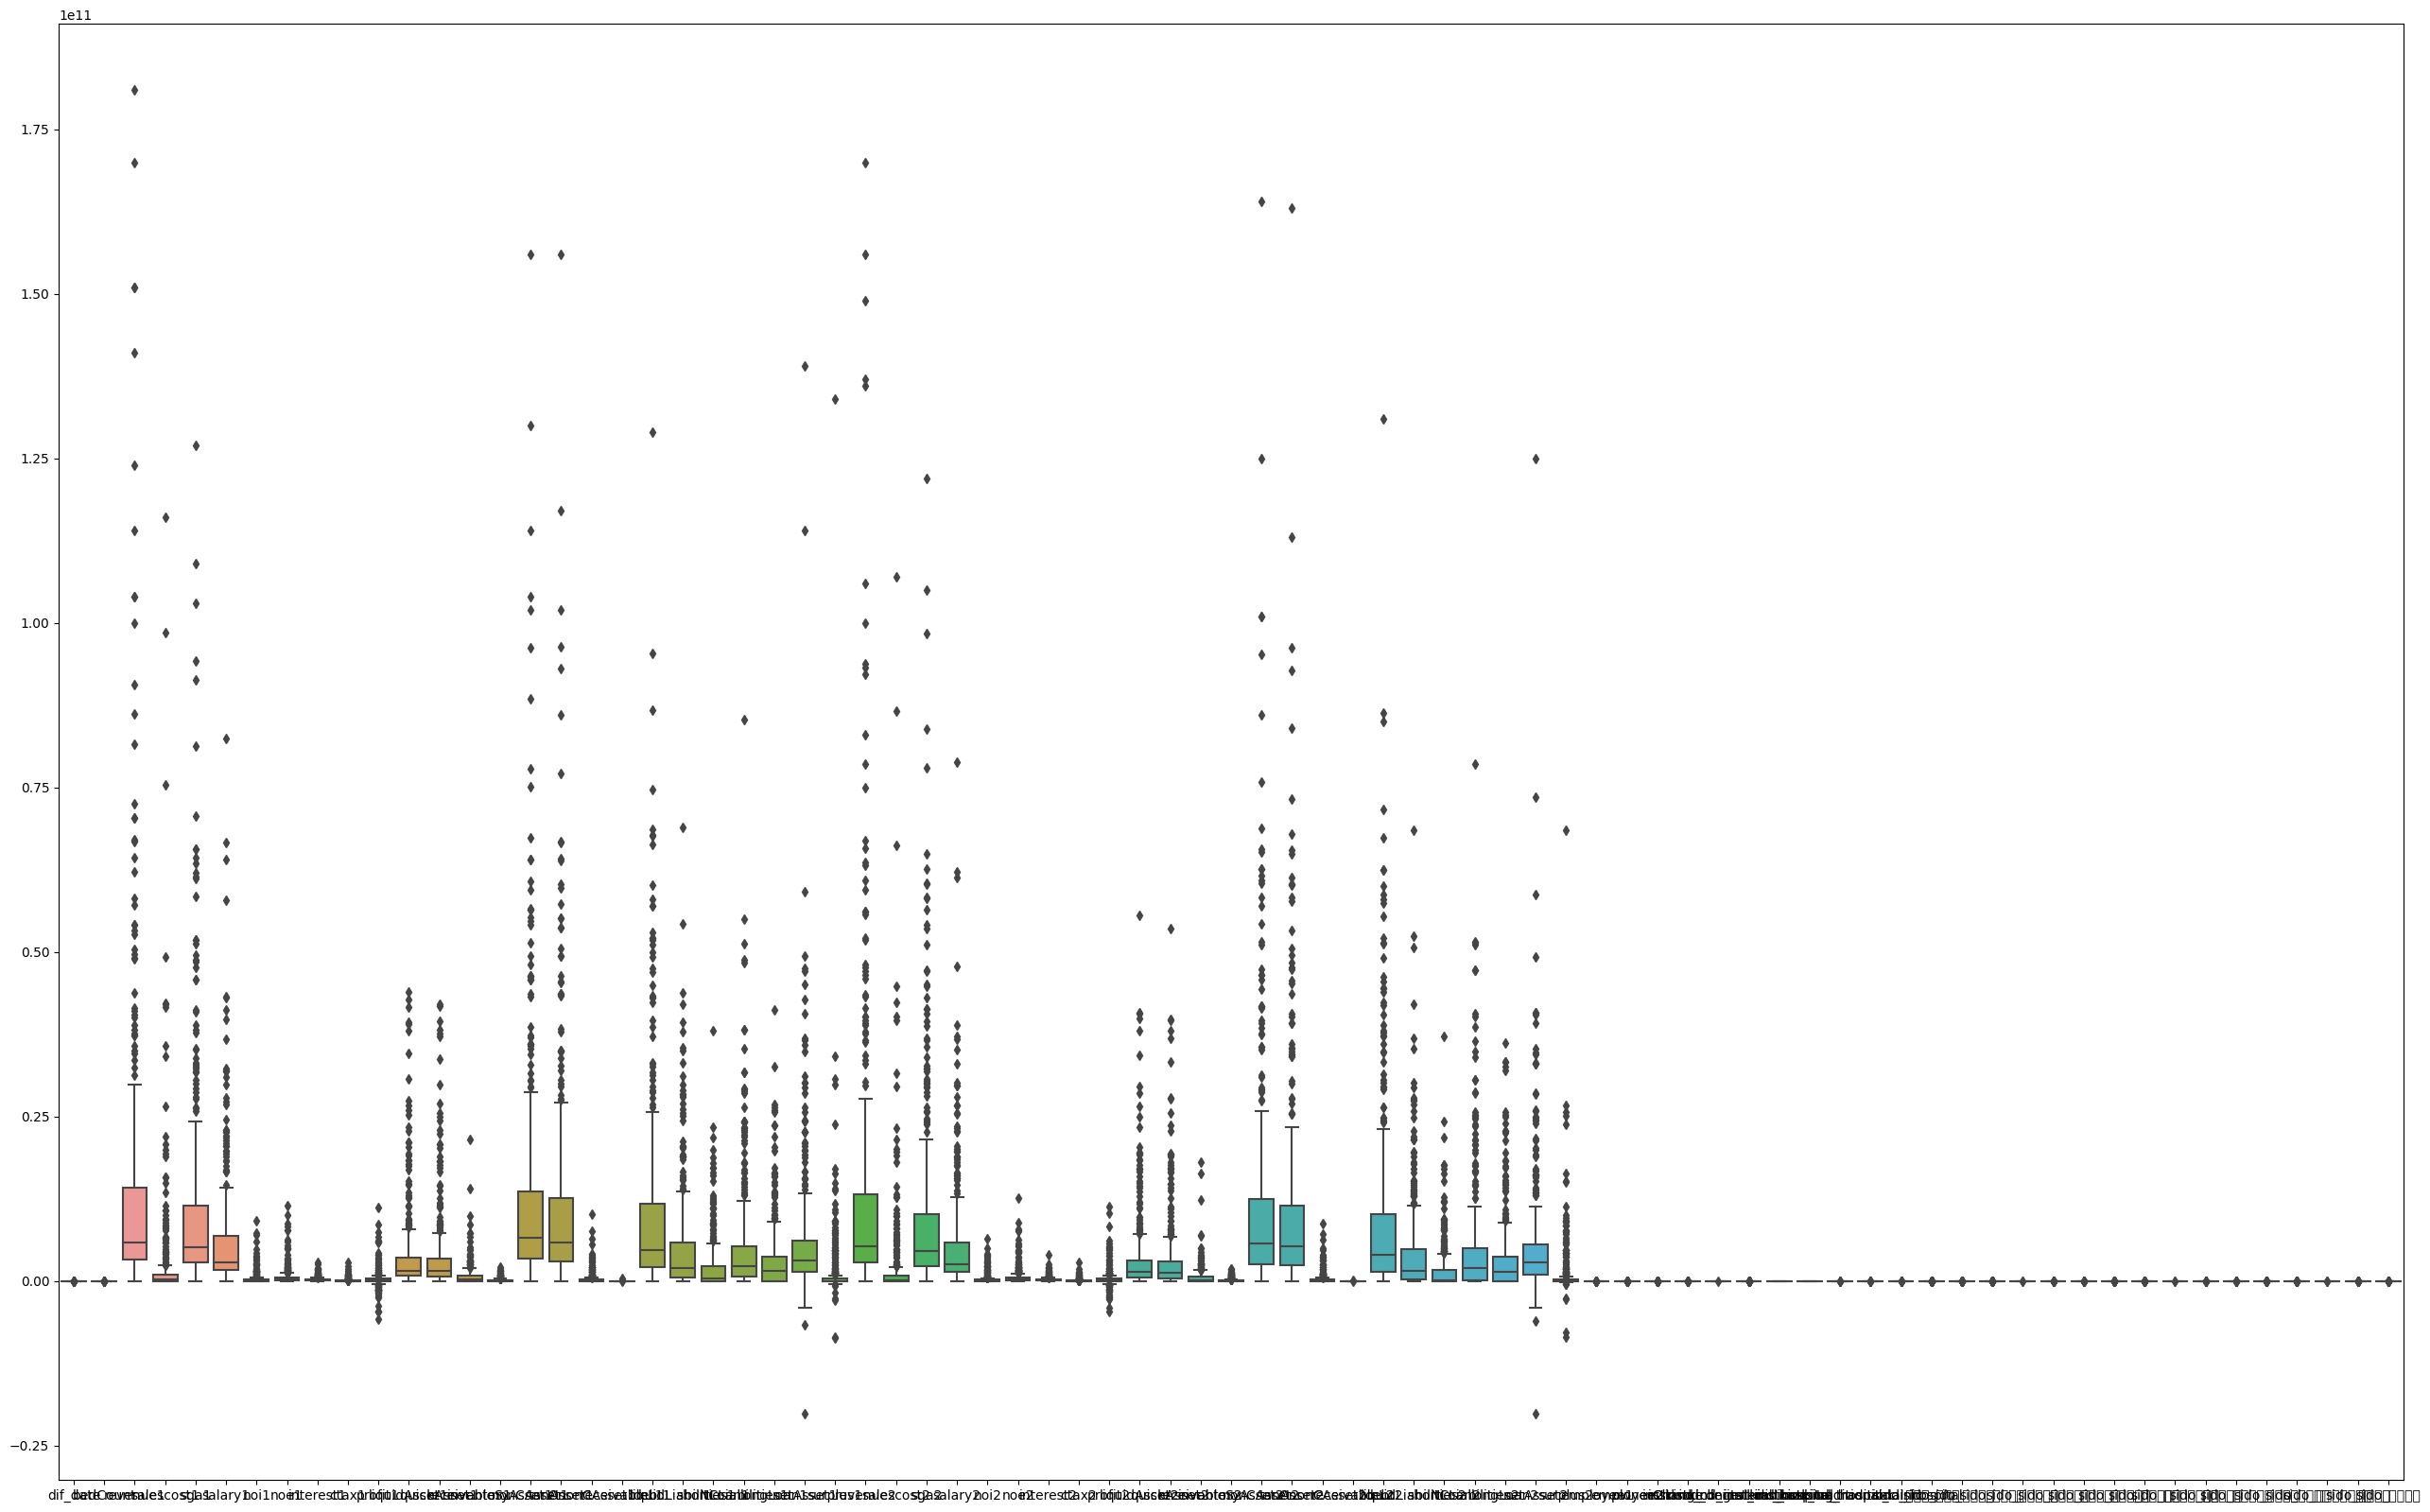

In [30]:
# scaling 전 독립 변수들의 데이터 분포를 살펴봄

plt.figure(figsize=(32,20))

sns.boxplot(data=df_m.iloc[:, 2:])

plt.show()

# 이상치가 많음

(**matplotlib**와 **seaborn** 라이브러리는 python에서 데이터 시각화에 대한 기능을 제공합니다.)

최대와 최소를 표시하는 수평선 위 아래로, 점으로 표시된 값을 확인할 수 있습니다.  
  
저 값들이 이상치인데요.  
  
한눈에 보기에도 너무 많죠?  
  
이상치의 수가 적다면 이상치를 제거하고 데이터를 분석해도 되지만,  
  
저희는 함부로 제거할 수 없습니다.  
  
그 이유는  
  
1. 이상치라 생각하고 데이터를 제거했을 때, 분석할 데이터 수가 적어진다.  
  
2. 병원 운영과 관련된 여러 지표(매출이나 이익, 직원 수 등)가 병원마다 상이할텐데, 저 값들을 이상치로 치부할 수 있을까?  
  
와 같은 이유가 있습니다.  
  
<br>
  
그 다음은 여러 컬럼 중 하나의 **histogram**과 **Q-Q plot**을 그려보겠습니다.  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [32]:
df_m.columns

Index(['inst_id', 'OC', 'dif_date', 'bedCount', 'revenue1', 'salescost1',
       'sga1', 'salary1', 'noi1', 'noe1', 'interest1', 'ctax1', 'profit1',
       'liquidAsset1', 'quickAsset1', 'receivableS1', 'inventoryAsset1',
       'nonCAsset1', 'tanAsset1', 'OnonCAsset1', 'receivableL1', 'debt1',
       'liquidLiabilities1', 'shortLoan1', 'NCLiabilities1', 'longLoan1',
       'netAsset1', 'surplus1', 'revenue2', 'salescost2', 'sga2', 'salary2',
       'noi2', 'noe2', 'interest2', 'ctax2', 'profit2', 'liquidAsset2',
       'quickAsset2', 'receivableS2', 'inventoryAsset2', 'nonCAsset2',
       'tanAsset2', 'OnonCAsset2', 'receivableL2', 'debt2',
       'liquidLiabilities2', 'shortLoan2', 'NCLiabilities2', 'longLoan2',
       'netAsset2', 'surplus2', 'employee1', 'employee2', 'ownerChange',
       'instkind_clinic', 'instkind_dental_clinic',
       'instkind_general_hospital', 'instkind_hospital',
       'instkind_nursing_hospital', 'instkind_traditional_clinic',
       'instkind_traditiona

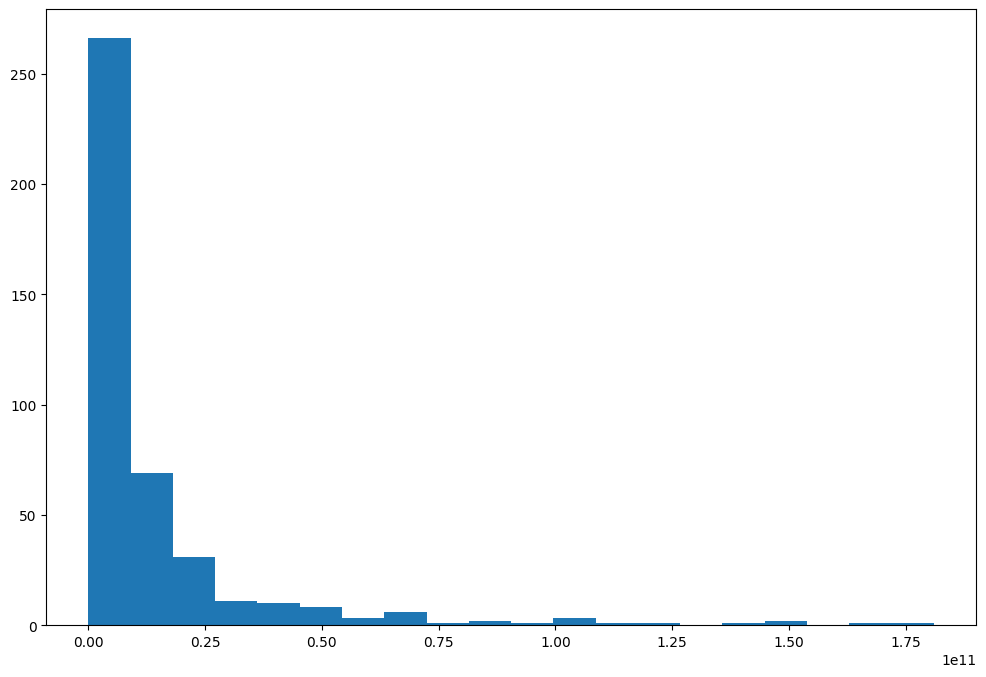

In [37]:
# histogram
plt.figure(figsize=(12,8))

plt.hist(df_m["revenue1"], bins=20)

plt.show()

<Figure size 1000x500 with 0 Axes>

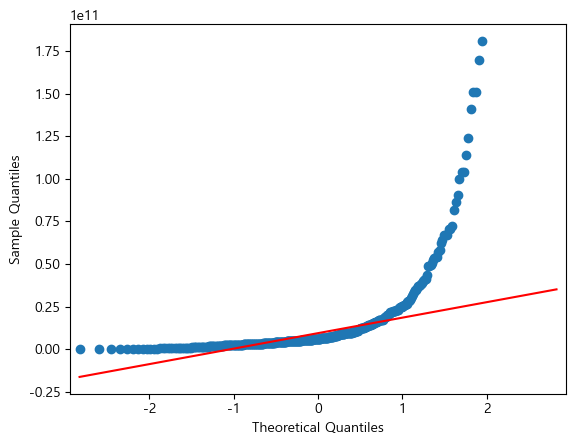

In [52]:
# Q-Q plot

# statsmodels는 통계 분석을 위한 다양한 기능을 제공하는 라이브러리 입니다.
import statsmodels.api as sma

plt.figure(figsize=(10,5))    # 그래프 사이즈 지정
sma.qqplot(data=df_m["revenue1"], dist=stats.norm, line='q')
plt.show()

첫 번째 차트는 histogram이고, 두 번째는 Q-Q plot 입니다.  
  
데이터 정규 분포에 근사하다면 아래 사진과 같이  
<img src="../data/히스토그램.png" width="600px" height="450px" title="히스토그램"></img><br>
  
종 모양과 같은 형태를 띄지만, 저희가 본 2017년 매출액은 그렇지 못 하죠.  
  
Q-Q plot의 경우 데이터가 정규 분포에 근사하다면,  
  
데이터 분포가 빨간색 직선과 동일하게 직선에 가까워집니다.  
  
직선과 동떨어질 수록 정규 분포가 아니라는 얘기입니다.  
  
하나의 컬럼만 정규 분포가 아닐 수도 있으니 전체 컬럼을 다 확인해 보시죠.  
  
함수를 만들어 확인하겠습니다. 

In [118]:
def show_qq(DF, colList : list) :
    """
    각 컬럼별 Q-Q plot을 확인합니다.
    DF : 정규성을 확인하고자 하는 data를 입력합니다. pandas의 DataFrame 형태입니다.
    colList : 정규성을 확인하고자 하는 data의 컬럼명 리스트입니다.
    """
    import math
    fig, axs = plt.subplots(figsize=(32, 72), nrows=int(math.ceil(len(colList)/5)), ncols=5)
    # axs는 numpy ndarray 형식

    # 한글 폰트 설정 및 깨짐 방지
    plt.rcParams['font.family'] = 'Malgun Gothic'
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    for c in range(int(len(colList))):
        sma.qqplot(data=DF[colList[c]], dist=stats.norm, line='q', ax=axs[(c//5),(c % 5)])
        axs[(c//5),(c % 5)].set_title("Name of Column :"+ colList[c])

    plt.show()

    return

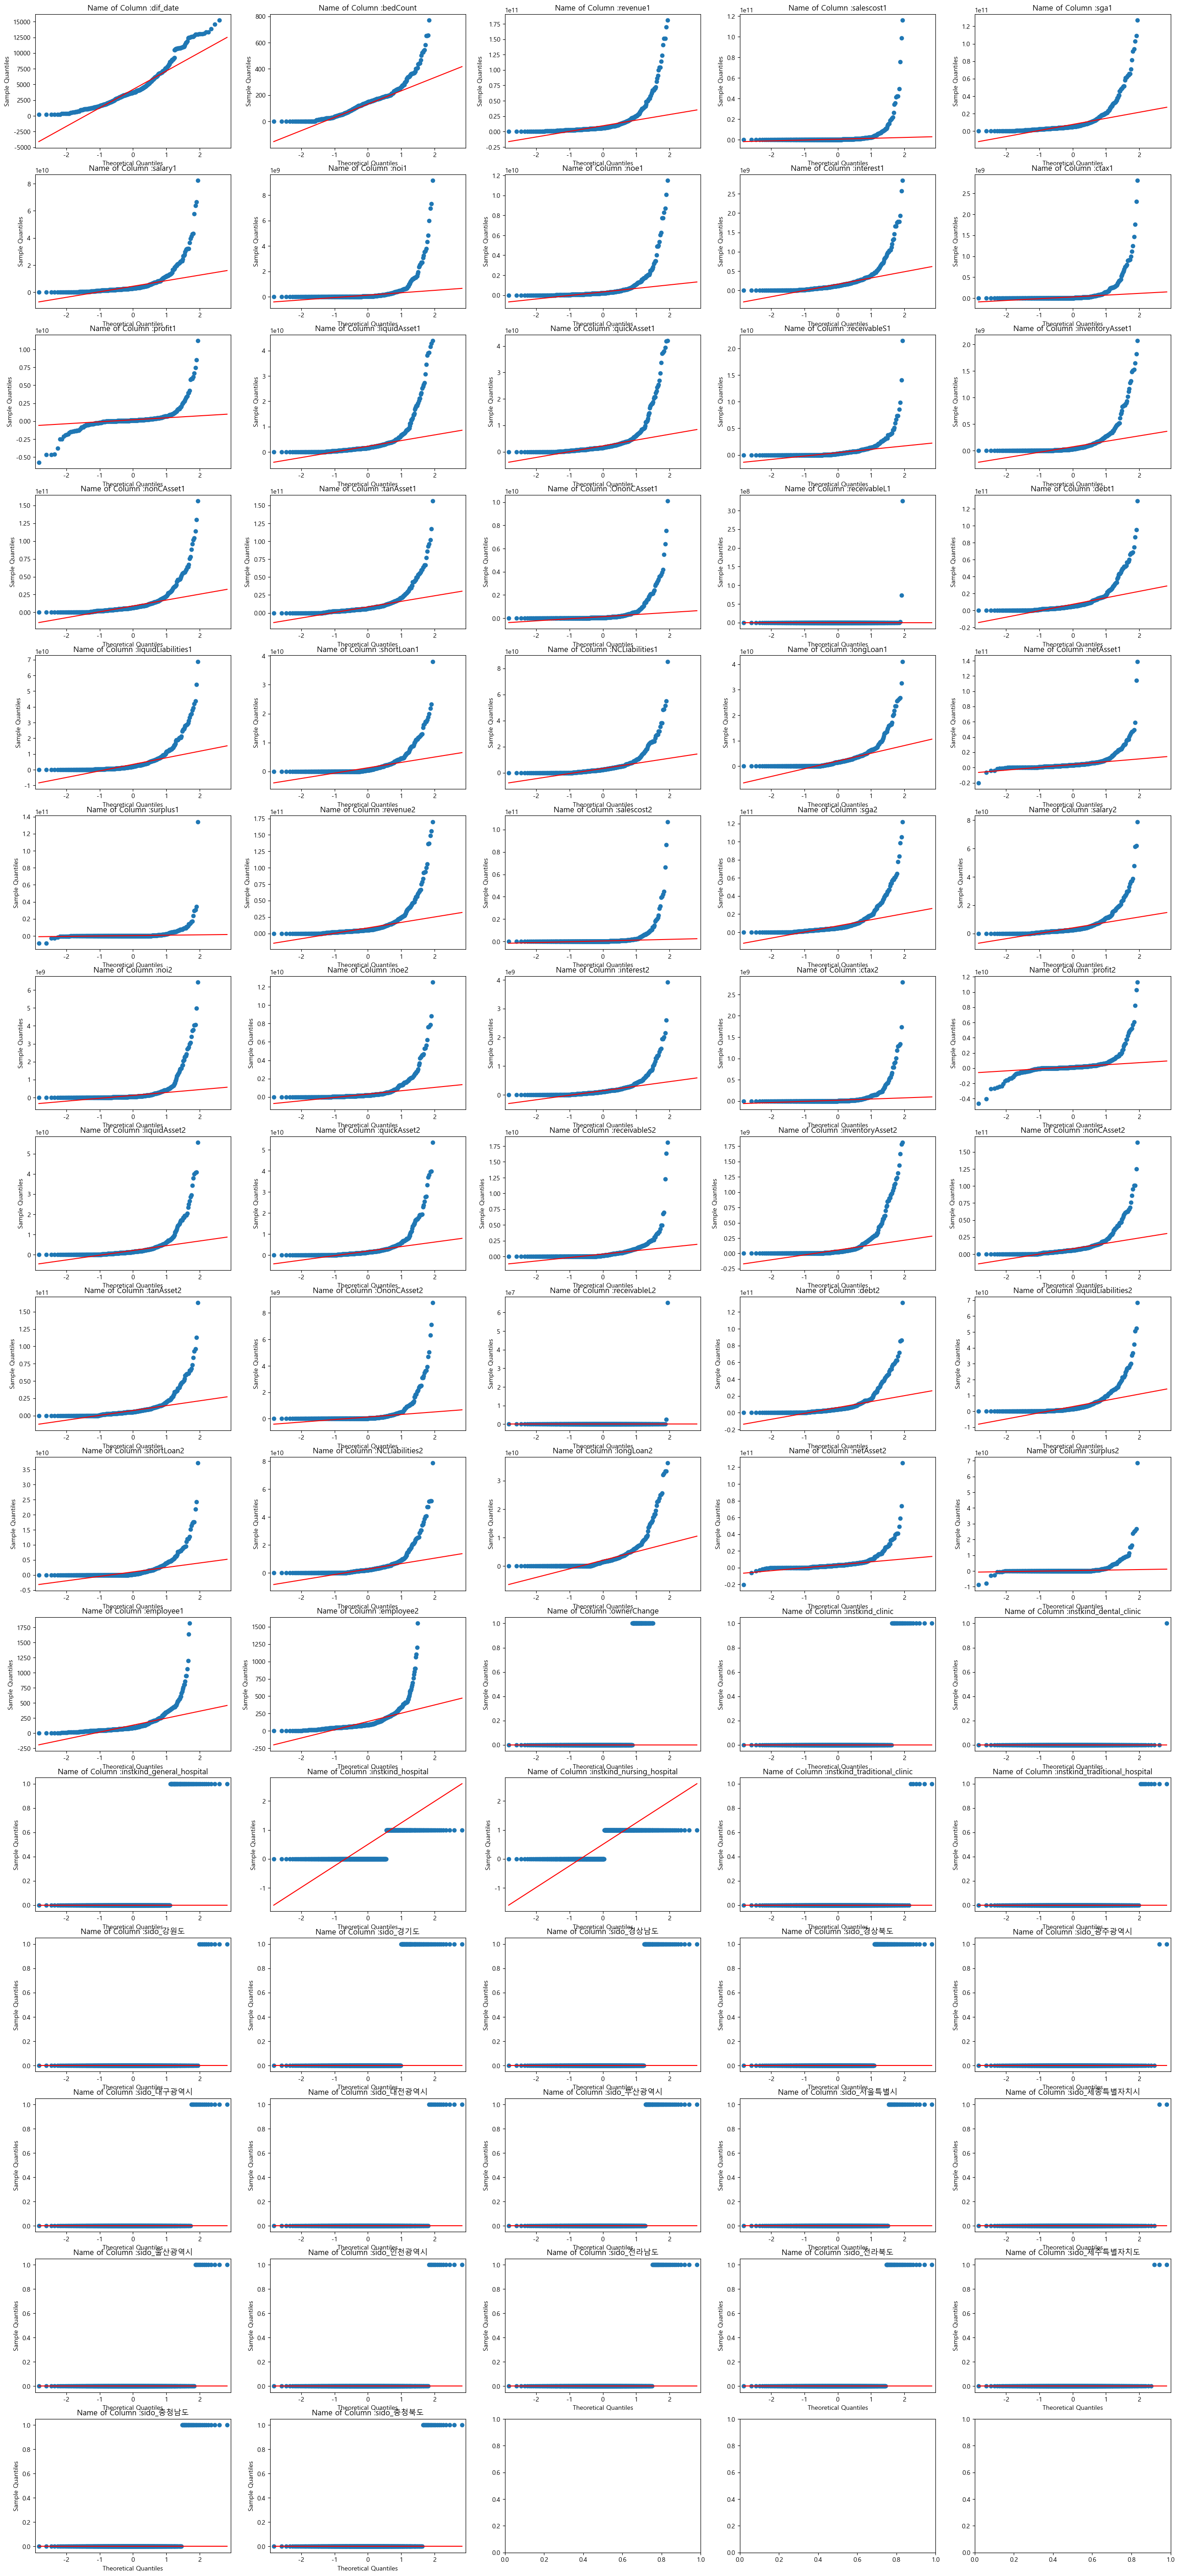

In [119]:
# 전체 컬럼의 정규성 확인
show_qq(DF=df_m, colList=df_m.columns.to_list()[2:])

지정한 데이터 전체의 Q-Q plot을 확인해 보니, 대부분의 데이터가 정규 분포를 따르지 않는 것을 확인할 수 있습니다.  
  
즉, 우리가 사용하는 데이터는 
  
1. 이상치로 간주되는 데이터가 대부분이다. >> minmaxscaler는 이상치의 영향을 많이 받기에 사용할 수 없다.
  
2. 데이터의 대부분이 정규 분포를 따르지 않는다. >> standardscaler를 사용할 수 없다.  
  
위와 같은 이유로, **robustscaler**를 사용해 데이터를 스케일링 하겠습니다.  
  
아래와 같이  
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [ ]:
from sklearn.preprocessing import RobustScaler

**sklearn** 라이브러리는 데이터 분석과 머신 러닝 모델 학습에 관련된 기능을 제공하는 라이브러리입니다.  
  
굉장히 자주 사용하는 라이브러리이니 친숙해 지도록 합시다🫡

In [67]:
# robustscaler

scaler1 = RobustScaler()

scaler1.fit(df_m.iloc[:,2:])

X = scaler1.transform(df_m.iloc[:,2:])

X.shape

(428, 77)

1. robustscale을 수행하는 RobustScaler()를 변수에 저장합니다. ( robustscale = (data – median / IQR) )  
  
2. 데이터 프레임에서 독립 변수인 컬럼만 fit() 메서드에 넣어 중앙값과 분위수를 계산합니다.  
  
3. transform() 메서드에 독립 변수 데이터를 넣어, 스케일링을 한 값으로 바꿔 줍니다.  
  
변환된 데이터 X를 한번 확인하면

In [68]:
print(X)

[[-0.01141987  0.24242424 -0.14419695 ...  0.          1.
   0.        ]
 [ 0.98413907  2.02272727         nan ...  0.          0.
   0.        ]
 [-0.84583175  2.46212121 -0.43671958 ...  0.          0.
   0.        ]
 ...
 [ 0.63621368  0.0530303   0.76852374 ...  0.          0.
   0.        ]
 [ 0.62834666         nan  3.92630651 ...  1.          0.
   0.        ]
 [ 1.01103921 -0.35606061  0.46642178 ...  0.          0.
   1.        ]]


위와 같이 변환된 것을 확인할 수 있습니다.

***
머신 러닝 모델 학습을 위해 데이터를 분리해 볼까요?

처음에 train.csv와 test.csv로 나눠져 있었기 때문에 처음 그대로 나눠야 합니다!⌨️  
  
train.csv 데이터만 모델 학습에 사용해 봅시다.

In [48]:
train_X = X[:301]
test_X = X[301:]
train_y = df_m.iloc[:301,1]
test_y = df_m.iloc[301:,1]

print("train 독립변수 크기 : ", train_X.shape)
print("test 독립변수 크기 : ", test_X.shape)
print("train 종속변수 크기 : ", train_y.shape)
print("test 종속변수 크기 : ", test_y.shape)

train 독립변수 크기 :  (301, 77)
test 독립변수 크기 :  (127, 77)
train 종속변수 크기 :  (301,)
test 종속변수 크기 :  (127,)


그 다음 train.csv 데이터를,  
  
학습용 데이터와 테스트용 데이터로 분리하겠습니다.  
  
sklearn의 **train_test_split()** 메서드를 사용해 줍니다.

In [100]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(train_X, train_y, test_size=0.2,random_state=10, stratify=train_y)

train_test_split() 메서드의 파라미터는 
  
* 독립 변수 X를 train용과 test용으로 분리한 후 각 변수에 저장합니다.  
  
* 종속 변수 y를 train용과 test용으로 분리한 후 각 변수에 저장합니다.  
  
* test_size의 비율을 데이터의 20%로 설정합니다. (train : test = 0.8 : 0.2)  
  
* random_state 파라미터로 난수를 생성해, 동일한 난수 조건에서 동일한 결과가 나오도록 설정합니다.  
  
* stratify 파라미터에 해당하는 값의 비율이 동일하게 분리됩니다.  
  
stratify 파라미터를 설정하는 이유는 개/폐업의 비율이 동일하지 않아 제대로 된 예측이 안 될 수 있기 때문입니다.  
  
만약 분리를 했는데 train set에는 폐업한 데이터가 안 들어가고 test set에만 들어간다면, 모델은 폐업에 대한 예측을 정확히 할 수 없을 수도 있기에,  
  
stratify로 개/폐업의 비율을 동일하게 분리해 줍니다.

In [76]:
print('train의 폐업 비율 : ',len(y_train1[y_train1==0])/len(y_train1))
print('test의 폐업 비율 : ',len(y_test1[y_test1==0])/len(y_test1))

train의 폐업 비율 :  0.05
test의 폐업 비율 :  0.04918032786885246


***
이제 모델에 학습을 하고 테스트를 해 볼까요?  
  
제가 사용할 모델은 **xgboost** 입니다.  
  
'xgboost'는 여러 개의 기본 모델을 활용하여 하나의 새로운 모델을 만들어내는 개념인 앙상블(Ensemble) 모델에서,  
  
오분류된 데이터에 초점을 맞추어 더 많은 가중치를 주어, 약분류기로 강분류기를 만드는 방식인 'boosting'이 적용된 모델입니다.  
  
과적합의 뛰어난 내구성을 가지고 있으며, 회귀 / 분류 성능이 뛰어납니다.  
    
또한 결측치에 대해서 default direction을 찾아내 그 방향으로 보내버림으로써 결측치를 효율적으로 다루게 됩니다.  
  
결측치가 많은 병원 개/폐업 데이터에는 유용한 모델이라고 생각합니다. 
  
아래와 같이 default 값으로 모델을 생성하고 학습해 봅시다. 
  
#### <span style="color:#99FFFF; background-color:#111111">예시 코드</span> 

In [101]:
model_xgb_1 = XGBClassifier()
xgb_model_1 = model_xgb_1.fit(X_train1, y_train1)

y_pred_1 = xgb_model_1.predict(X_test1)
print("정확도 : ",round(accuracy_score(y_test1, y_pred_1),4))
print("f1 socre : ",round(f1_score(y_test1, y_pred_1),4))

정확도 :  0.9672
f1 socre :  0.9831


정확도 :  0.9672  
f1 socre :  0.9831

1. XGBClassifier() 모델을 변수에 저장한 후  
  
2. fit() 메서드에 train 데이터를 학습시킵니다.  
  
3. predict() 메서드에 test 독립 변수를 넣어 결과를 예측한 뒤  
  
4. 평가 지표를 이용해 모델의 성능을 확인합니다.  
    * 정확도(accuracy) : 전체 예측한 결과 중에서 실제로 예측에 성공한 비율입니다. ( (TP + TN) / (TP + FP + TN + FN) )  
      
    * f1 score : 정밀도와 재현율의 조화 평균으로 domain의 편향을 보완할 수 있는 지표입니다. ( 2 * (정밀도의 역수 + 재현율의 역수)의 역수 )  
  
정확도와 f1 score가 높게 예측됐습니다.  
  
저희가 만든 모델에 train 데이터를 넣은 예측 값은 얼마나 잘 예측할 수 있을까요?

In [120]:
y_pred_tr_1 = xgb_model_1.predict(X_train1)
print("정확도 : ",round(accuracy_score(y_train1, y_pred_tr_1),4))
print("f1 socre : ",round(f1_score(y_train1, y_pred_tr_1),4))

정확도 :  1.0
f1 socre :  1.0


세상에! 정확도가 '**1**' 이 나왔습니다 여러분!!  
  
어쩜 이럼 완벽한 모델이~~  
  
라고 생각하시면 안 됩니다.  
  
우리는 이것을 ***과대적합(overfitting)*** 혹은 과적합 됐다고 얘기합니다.  
  
모델이 학습 데이터에 너무 딱 맞아진 현상으로,  
  
과적합이 되면 테스트 데이터에 대해 낮은 예측 성능을 보이게 됩니다.  
  
비록 우리의 모델이 테스트 데이터에 대해 낮지 않은 성능을 보였어도,  
  
1. **학습용 데이터에 지나치게 높은 성능을 보이고**  
    
2. **테스트 데이터의 평가 지표와 (큰)차이를 보일 때**  
  
과적합이 됐다고 판단합니다😡

과적합된 우리 모델은 폐업한 데이터를 잘 예측해 주었을까요?  
  
아래 코드를 통해 확인해 보시죠

In [102]:
print("테스트 종속 변수에서 폐업(0)의 위치(인덱스) : ",np.where(y_test1==0)[0])
print("---------------------------------------")
print("예측한 종속 변수에서 폐업(0)의 위치(인덱스) : ",np.where(y_pred_1==0)[0])

테스트 종속 변수에서 폐업(0)의 위치(인덱스) :  [ 6 22 44]
---------------------------------------
예측한 종속 변수에서 폐업(0)의 위치(인덱스) :  [44]


전체 폐업 수 3개 중 1개를 맞혔으니 특이도(specificity)( TN / (TN+FP) )는 **0.3333**이 나왔습니다.  
  
초기에 설정한 분석 방향으로 봤을 때, 개업을 유지하는 병원보다 폐업할 병원을 예측하는 것이 더 중요하기 때문에  
  
현재 특이도는 불만족스러울 수 밖에 없네요.  
  
특이도를 계속 보기 위해 함수로 만들어 봅시다.

In [115]:
def show_specificity(test, predict) : 
    """
    테스트 데이터와 예측 값의 특이도를 확인하기 위한 함수입니다.
    test : 테스트 종속 변수 입니다. 
    predict : 종속 변수 예측 값 입니다.
    두 데이터의 타입은 numpy.ndarray 혹은 pandas.core.series.Series 입니다.
    """
    import numpy as np

    LengthTest = len(np.where(test==0)[0])
    LengthPred = len(np.where(predict==0)[0])

    return print("특이도 : ", round((LengthPred/LengthTest),4))

In [117]:
show_specificity(y_test1, y_pred_1)

특이도 :  0.3333


***
그럼 저희가 만든 머신러닝 모델과 거기에 쓰인 스케일러를 저장하고,  
  
다시 불러와 test.csv의 값을 예측해 봅시다.  
  
아래와 같이 함수 2개를 만들겠습니다.  
  
하나는 모델과 스케일러 저장, 또 다른 하나는 test.csv 값 예측입니다.

In [128]:
def save_model(model, scaler, name : str) : 
    import joblib  # joblib 라이브러리로 모델과 스케일러를 .pkl 확장자 저장
    # model 저장
    joblib.dump(model, dirShare+"/model/pred_xgb_output_hosOC_"+name+".pkl")

    # scaler 저장
    joblib.dump(scaler, dirShare+"/model/pred_xgb_output_hosOC_sc_f_"+name+".pkl")

In [139]:
def open_pred(dir_model, data, dir_scaler = None) : 
    # 모델 불러오기

    # byte로 불러오기
    # with문으로 파일을 open 하면 실행이 끝나고 자동으로 close
    with open(str(dir_model), "rb") as m :
        model = joblib.load(m)

        if dir_scaler is not None : 
            with open(str(dir_scaler), "rb") as s :  
                scaler = joblib.load(s)
                data = scaler.transform(data)

                val_pred = model.predict(data)
                
                return val_pred

        else : 
            val_pred = model.predict(data)
                
            return val_pred

In [129]:
# 모델을 저장하겠습니다.

save_model(model=model_xgb_1, scaler=scaler1, name="origin")

모델을 저장해 놓는 폴더에, 모델과 스케일러가 저장된 것을 확인할 수 있습니다.  
  
그럼 불러와서 값을 예측해 보겠습니다.

In [140]:
predict1 = open_pred(dir_model=dirShare+"/model/pred_xgb_output_hosOC_origin.pkl", data=test_X)
print(predict1)

[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0]


***
'inst_id' 컬럼과 비교해 어느 병원이 폐업하는지 예측해 보겠습니다.

In [163]:
def close_hos(predict, hos_id) : 
    import numpy as np
    idx_close1 = np.where(predict==0)[0].tolist()

    result1 = hos_id.iloc[301:,0][idx_close1].to_list()

    print("폐업한 병원의 id는",", ".join(map(str,result1)),"입니다.")

In [164]:
# 폐업한다 예측된 병원은 어디?
close_hos(predict=predict1, hos_id=df_m)

폐업한 병원의 id는 6, 123, 165, 229, 254, 341, 424, 430, 431 입니다.


9개의 병원이 폐업했다고 예측했지만, 과적합된 모델이 내어 놓은 값이기에 완전 신뢰할 수는 없습니다.  
  
(수가 적은 데이터의 경우 cross_validation으로 과적합을 줄일 수 있지만 다양한 방법을 수행한 후, 일부를 선택해서 진행하겠습니다.)

***
다음 분석에서는 특성 선택을 독립 변수의 수를 줄여보도록 하겠습니다📏  
  
저희와 같이 동행하느라 수고하셨습니다!!🤗🤗

In [111]:
# # predict_proba는 해당 값으로 분류될 확률
# y_pred_1_prob = xgb_model_1.predict_proba(X_test1)
# # y_pred_1_prob
# score1 = y_pred_1_prob[:,1]
# fpr1, tpr1, cut1 = roc_curve(y_test1,score1)

# plt.figure(figsize=(8,6))

# plt.plot(fpr1, tpr1, label="xgb_origin1")
# plt.plot([0,1], [0,1], color='red', label='Random Model')
# plt.legend()
# plt.show()

## 분석 2. 차원 축소 후 모델 학습(vif >= 10 이상 제외)

### statsmodels를 사용한 vif 계산

In [55]:
# 병원 개/폐업 정보의 다중 회귀 분석과 검정 통계량 확인
Models1 = sm.ols("OC ~ " + "+".join(df_m.columns[2:]), data=df_m.iloc[:,1:])
result1 = Models1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                     OC   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     1.899
Date:                Mon, 21 Aug 2023   Prob (F-statistic):           0.000248
Time:                        11:44:15   Log-Likelihood:                 190.95
No. Observations:                 277   AIC:                            -235.9
Df Residuals:                     204   BIC:                             28.66
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [56]:
# vif를 계산해주는 메서드는 결측치를 계산해주지 않음
df_m_drop = df_m.dropna(axis=0, how="any")
df_m_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 0 to 296
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        277 non-null    int64  
 1   OC                             277 non-null    float64
 2   dif_date                       277 non-null    float64
 3   bedCount                       277 non-null    float64
 4   revenue1                       277 non-null    float64
 5   salescost1                     277 non-null    float64
 6   sga1                           277 non-null    float64
 7   salary1                        277 non-null    float64
 8   noi1                           277 non-null    float64
 9   noe1                           277 non-null    float64
 10  interest1                      277 non-null    float64
 11  ctax1                          277 non-null    float64
 12  profit1                        277 non-null    float64


In [57]:
# 독립변수만 분리
X_dr = df_m_drop.iloc[:,2:]

In [58]:
# 독립변수들간 다중 공선성 확인, vif 지수 10 이상이면 변수 제거 고려
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_dr.values,i) for i in range(X_dr.shape[1])]
vif["features"] = X_dr.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.537,ownerChange
1,2.126,dif_date
2,3.340,bedCount
3,6.736,receivableS2
4,7.251,receivableS1
...,...,...
72,66719994479562.906,sido_경기도
73,105967050055776.375,instkind_hospital
74,NaN,receivableL1
75,NaN,receivableL2


In [59]:
# vif 지수가 10미만인 컬럼명
vif[vif["VIF Factor"]<10.0]["features"]

0     ownerChange
1        dif_date
2        bedCount
3    receivableS2
4    receivableS1
Name: features, dtype: object

In [60]:
feat_vif = vif[vif["VIF Factor"]<10.0]["features"]

fvList = [feat_vif[f] for f in range(len(feat_vif))]

In [61]:
numList = []
for f in fvList : 
    idx = df_m.columns.to_list().index(f)
    numList.append(idx)

print("차원 축소된 컬럼의 인덱스 : ", numList)

차원 축소된 컬럼의 인덱스 :  [54, 2, 3, 39, 15]


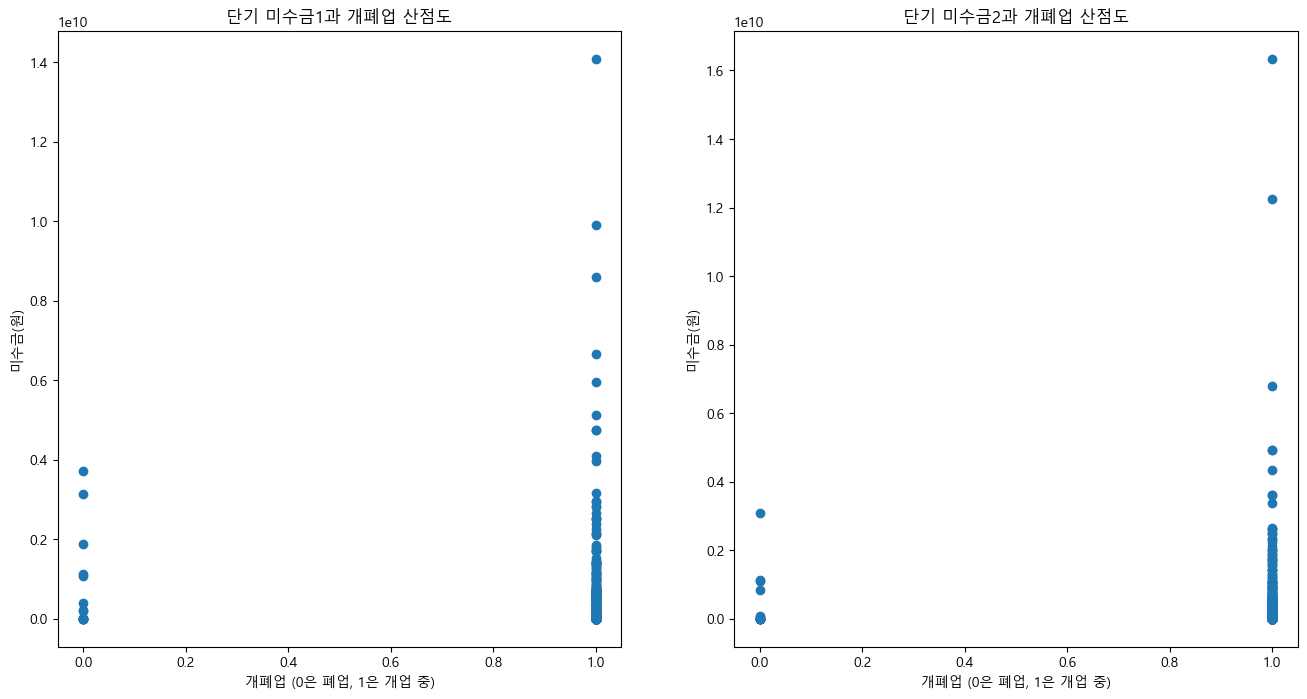

In [35]:
# # 데이터프레임에서 변수간 상관 계수 계산
df_scatter = df_m.iloc[:,numList+[1]]

fig, axs = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)

# 한글 폰트 설정 및 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

for c in range(2):
    axs[c].scatter(x=df_scatter["OC"], y=df_scatter["receivableS"+str(c+1)])
    axs[c].set_title('단기 미수금'+ str(c+1)+'과 개폐업 산점도')
    axs[c].set_xlabel("개폐업 (0은 폐업, 1은 개업 중)")
    axs[c].set_ylabel("미수금(원)")

# plt.scatter(x=df_scatter["OC"], y=df_scatter["receivableS2"])
plt.show()

In [62]:
train_X_vif = train_X[:,numList]
test_X_vif = test_X[:,numList]

print("차원 축소된 train 독립변수 크기 : ", train_X_vif.shape)
print("차원 축소된 test 독립변수 크기 : ", test_X_vif.shape)

차원 축소된 train 독립변수 크기 :  (301, 5)
차원 축소된 test 독립변수 크기 :  (127, 5)


In [63]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_X_vif, train_y, test_size=0.2,random_state=50, stratify=train_y)

model_xgb_2 = XGBClassifier()
xgb_model_2 = model_xgb_2.fit(X_train2, y_train2)

y_pred_2 = xgb_model_2.predict(X_test2)
print("정확도 : ",round(accuracy_score(y_test2, y_pred_2),3))
print("f1 socre : ",round(f1_score(y_test2, y_pred_2),3))

정확도 :  0.967
f1 socre :  0.983


검증용 test 데이터에 대한 정확도  

정확도 :  0.967  
f1 socre :  0.983

In [64]:
y_pred_2_5 = xgb_model_2.predict(X_train2)
print("정확도 : ",round(accuracy_score(y_train2, y_pred_2_5),3))
print("f1 socre : ",round(f1_score(y_train2, y_pred_2_5),3))

정확도 :  0.983
f1 socre :  0.991


모델 train 데이터에 대한 정확도  

정확도 :  0.983  
f1 socre :  0.991

차원 축소에서 선택된 컬럼이 대표성을 지니지 않음😱
- 단기 미수금

## 분석 3. 결측치를 채운 후 모델 학습

### 인구 데이터 합치기

In [43]:
# 2017년 지역별 인구수 데이터
# https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3
pop = pd.read_csv(dirShare+"/data/행정구역_시군구_별__성별_인구수_20230718231833.csv", header=1, encoding="cp949")
# pop.info()
# pop.head()

In [44]:
# 컬럼명을 영어로 바꾸기
pop.rename(columns={"총인구수 (명)":"tt_pop", "남자인구수 (명)":"male_pop", "여자인구수 (명)":"female_pop"}, inplace=True)
# pop.columns

In [45]:
# df_one와 pop(인구수) join
df_new = pd.merge(df_one, pop, how="inner", left_on="sido", right_on="행정구역(시군구)별")
# df_new.head()

In [46]:
# 시도를 one-hot-encoding
df_new = sido_ohe(DF=df_new,colname="sido")
# df_new.columns

In [47]:
# 지역을 one-hot-encoding 했으므로 시군구 컬럼은 무의미
df_new.drop(columns=["sgg","행정구역(시군구)별"], axis=1, inplace=True)
# df_new.info()

### kmeans를 통한 병원 세그먼트 군집

In [48]:
def visualize_silhouette(cluster_lists, X_features): 

    """
    함수 출처 : https://dev-ryuon.tistory.com/83
    """

    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=100)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

<Axes: >

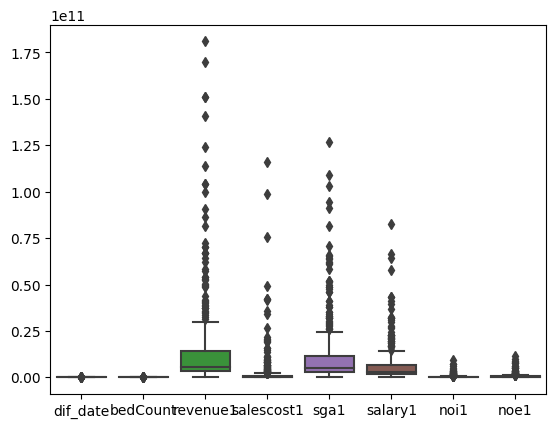

In [49]:
sns.boxplot(data=df_new.iloc[:, 2:10])

In [50]:
# NaN 값이 없는 컬럼만 남기고, 지역 데이터 없애기
df_kmeans = df_new.dropna(axis=1, how="any")
# df_kmeans.info()

In [51]:
scaler_cl = MinMaxScaler()

df_mmsc = df_kmeans.drop(columns=["inst_id"])

df_mmsc.dropna(how="any", axis=1, inplace=True)

# df_mmsc.info()

In [52]:
scalerX_cl = scaler_cl.fit(df_mmsc)

X_mmsc_cl = scaler_cl.transform(df_mmsc)

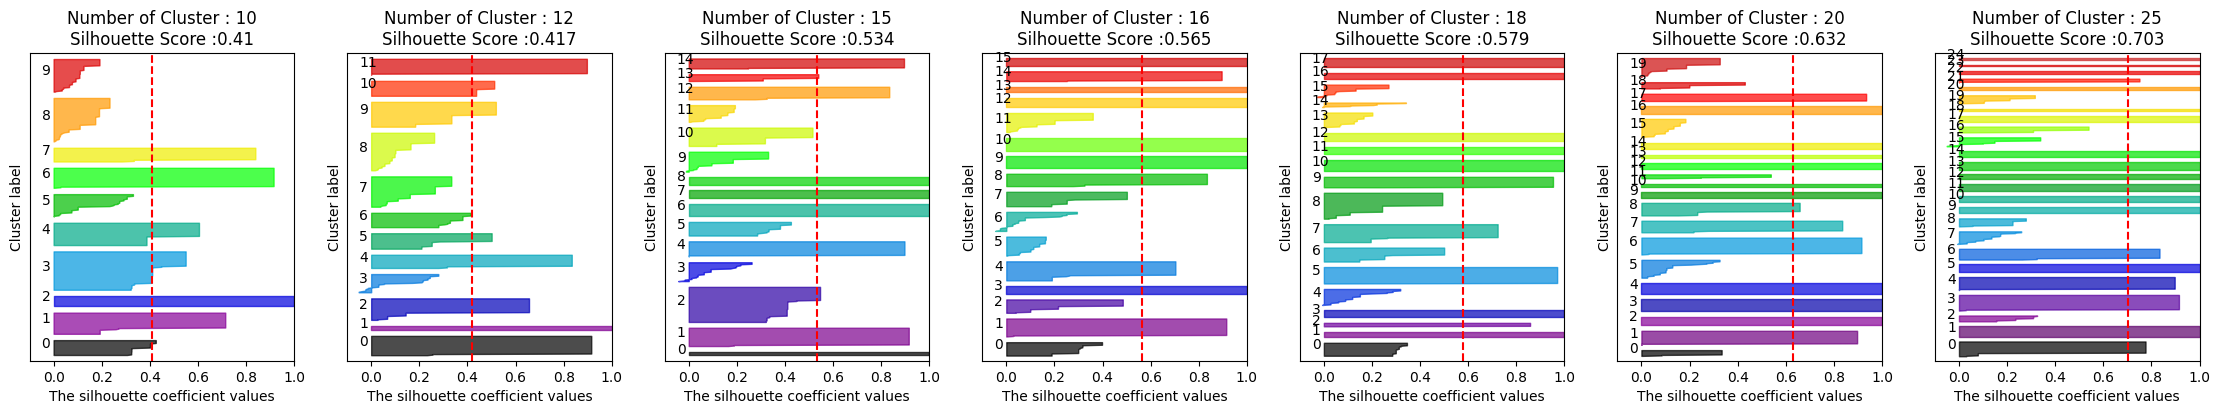

In [53]:
visualize_silhouette([10,12,15,16,18,20,25], X_mmsc_cl)
# 25개가 됐을 때 실루엣 계수가 0.703으로 최대

In [54]:
clst_kmeans = KMeans(n_clusters=25, random_state=100, max_iter=500)

model = clst_kmeans.fit(X_mmsc_cl)
clst_label = model.labels_

print(clst_label)

[ 6  6  7 19  6  6  6  6  6 19  6  6  6  6  6  6  6  6  6  6  6  6 19  6
  7  6  6  6  6  6  7  7  7  7  1  1 11  7 11 11  1  1  1 11  1  1  1 11
 11  1  1  1  7  1  1  1  1  1 11  1 11  1  1 11  1 11 11 11  1 11 11  1
  1 11  1 11  0 14 14 14  0  0  0  9  9 18  9  9  0  0  9 18  0  9  0  0
  0 18  0  0  0  0  9  0  0  9 14 14 18 14  9  0  9  0 18  0  0  0  9 14
 14 14  9  0  0 14 14  9  0 14  0  0  0 14  0  0  0 18  0  9  0  0  0  9
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  7  4  4  4  4  4  4  4  4  4
  4  4  7 22  4  4  4 22  4  4  4 22  4  4  4 22  7  7  7 22  4 22  4 22
  4  4  4  4 22  4  4  4  4 10 10 10 16 16 16 16 10 10 10 16 10 10 16 10
 10 10 10 16 16 10 16 16 10 16 10 16 16 16  8  8  8 20  8  8 20 20  8  8
  8 20  8  8 20  8  8 20  8 20  8  8  8 20  8  8  8  5  5  5 21  5  5  7
  5  5  5 21  5 21 21  5 21  5  7  7  7  5 21 21  5  5 21 21  5  5  5  5
 17 24 17 17 24 17 24 17 17 17 17 17 17 24  7 17 24 17 17 17 24  7  7 15
 19 15 19 19  7 15 15 15 19 19 15 15 15 19 15 15 15

In [55]:
df_kmeans["NumberOfCluster"] = pd.Series(clst_label)
# df_kmeans.tail()

In [56]:
# 재무 정보가 포함돼 있는 데이터 프레임에 클러스터링 넘버 삽입
df_join_clst = pd.merge(df_new, df_kmeans[["inst_id", "NumberOfCluster"]], how="inner", on="inst_id")
# df_join_clst.info()

In [57]:
df_join_clst.shape[0] - df_join_clst.count()

inst_id              0
OC                 127
dif_date             1
bedCount            13
revenue1            10
                  ... 
sido_전라북도            0
sido_제주특별자치도         0
sido_충청남도            0
sido_충청북도            0
NumberOfCluster      0
Length: 83, dtype: int64

In [58]:
# 군집별 히스토그램 확인

def sp_hist(DF=None, colClst=None, colhist=None, Range=None) :
    """
    군집별 특정 컬럼의 히스토그램을 확인합니다.

    DF : 히스토그램을 확인하고자 하는 데이터프레임
    colClst : 군집 번호를 표시하는 컬럼
    colhist : 히스토그램으로 표현하고자 하는 컬럼
    """
    
    fig, axs = plt.subplots(figsize=(16, 32), nrows=4, ncols=3)
    # axs는 numpy ndarray 형식

    # 한글 폰트 설정 및 깨짐 방지
    plt.rcParams['font.family'] = 'Malgun Gothic'
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    for c in range(Range):
        dataframe = DF[DF[colClst]==c][colhist]
        # print("현재 순서 :",c)
        # print("행 :", c//3)
        # print("열 :", c%3)
        axs[(c//3),(c % 3)].hist(dataframe, bins=20)
        axs[(c//3),(c % 3)].set_title('Number of Cluster : '+ str(c)+'\n' \
                            'Column Name :' + str(dataframe.name) )
        axs[(c//3),(c % 3)].set_xlabel("계급")
        axs[(c//3),(c % 3)].set_ylabel("도수")

    plt.show()

    return

In [59]:
# 군집별 boxplot 확인
def sp_boxplot(DF=None, colClst=None, colbox=None, Range=None) :
    plt.figure(figsize=(28,20))
    plt.rcParams['font.family'] = 'Malgun Gothic'
    matplotlib.rcParams['axes.unicode_minus'] = False

    # rectangular box plot
    DF_box = pd.DataFrame()

    for c in range(Range) : 
        dataframe = DF[DF[colClst]==c][colbox]
        dataframe.rename(str(c), inplace=True)
        DF_box = pd.concat([DF_box, dataframe], axis=1)

    sns.boxplot(
                data = DF_box,
                orient='v'
                ) 
    plt.title("클러스터 별 boxplot")

    plt.show()
    return

In [60]:
# sp_boxplot(DF=df_join_clst, colClst="NumberOfCluster", colbox="surplus1", Range=25)

In [61]:
# 군집별 중앙값으로 결측치 채움

def fill_median(DF=None, colClst=None, colFill=None, numclst=None) :
    """
    결측치가 있는 행 데이터에, 군집별 중앙값을 채워 넣고자 함

    DF : 히스토그램을 확인하고자 하는 데이터프레임
    colClst : 군집 번호를 표시하는 컬럼(str)
    colFill : 결측치를 채우고자 하는 컬럼 리스트(list)
    numclst : 클러스터 개수(int)
    """
    for cl in range(numclst) :
        for L in colFill :
            median_value = DF.loc[DF[colClst] == cl, L].median()
            DF.loc[(DF[colClst] == cl) & DF[L].isnull(), L] = median_value

    return DF

In [62]:
df_join_clst = fill_median(DF=df_join_clst, colClst="NumberOfCluster", 
                           colFill=df_join_clst.columns[2:82], numclst=25)

df_join_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        428 non-null    int64  
 1   OC                             301 non-null    float64
 2   dif_date                       428 non-null    float64
 3   bedCount                       428 non-null    float64
 4   revenue1                       428 non-null    float64
 5   salescost1                     428 non-null    float64
 6   sga1                           428 non-null    float64
 7   salary1                        428 non-null    float64
 8   noi1                           428 non-null    float64
 9   noe1                           428 non-null    float64
 10  interest1                      428 non-null    float64
 11  ctax1                          428 non-null    float64
 12  profit1                        428 non-null    flo

In [242]:
def arrange_tt(ldata, rdata, rcol : str) :
    """ merge 메서드를 사용하면 on 조건을 정렬 기준으로 삼음
    merge 이후 train 데이터와 test 데이터가 섞여 있으므로 다시 분리한 후 합쳐주는 작업 진행"""

    df_dvd_test = pd.merge(left=ldata, right=rdata[rcol], how="inner", on=rcol)
    # inst_id를 기준으로 오름차순 정렬
    df_dvd_test.sort_values(by=rcol, axis=0, ascending=True, inplace=True)

    df_dvd_train = pd.merge(left=ldata, right=rdata[rcol], how="outer", on=rcol, indicator=True)
    # inst_id를 기준으로 오름차순 정렬
    df_dvd_train.sort_values(by=rcol, axis=0, ascending=True, inplace=True)

    # test 데이터의 inst_id가 다른 데이터만 추출 >> train 데이터
    # indicator=True는 merge된 각 행의 정보를 알려줌
    # left에만 존재하는 행이라면 left_only
    # right에만 존재하는 행이라면 right_only
    # 둘 다 존재하면 both
    df_dvd_train = df_dvd_train[df_dvd_train["_merge"]=="left_only"].iloc[:,:df_dvd_train.shape[1]-1]

    DF = pd.concat([df_dvd_train, df_dvd_test], axis=0)

    return DF

In [63]:
df_join_clst = arrange_tt(df_join_clst, df_t, "inst_id")
df_join_clst.iloc[301:310,:]

,inst_id,OC,dif_date,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,sido_서울특별시,sido_세종특별자치시,sido_울산광역시,sido_인천광역시,sido_전라남도,sido_전라북도,sido_제주특별자치도,sido_충청남도,sido_충청북도,NumberOfCluster
37,2,NaN,6977.000,300.000,66824864410.000,0.000,65657092101.000,32236953402.000,4314093449.000,4901516562.000,...,0,0,0,1,0,0,0,0,0,2
124,5,NaN,663.000,44.000,34957575568.000,0.000,32592697196.000,16722544253.000,68710235.000,1981032861.000,...,0,0,0,0,0,0,1,0,0,19
58,6,NaN,10476.000,276.000,23260305967.000,2542570943.000,23087485220.000,11687337552.000,1601942757.000,1380941439.000,...,0,0,0,0,1,0,0,0,0,16
41,8,NaN,2866.000,363.000,0.000,0.000,0.000,0.000,4850652289.000,2060988817.000,...,0,0,0,0,0,0,0,0,0,7
74,10,NaN,4959.000,213.000,50370249897.000,0.000,48558027276.000,22963463015.000,1534452040.000,0.000,...,0,0,0,0,0,1,0,0,0,7
18,12,NaN,3295.000,220.000,43816543122.000,10051312608.000,29264928639.000,19715446217.000,3260366823.000,4892588017.000,...,0,0,0,0,0,0,0,0,0,14
19,13,NaN,5712.000,370.000,86227731973.000,21961377249.000,61519717053.000,39714189795.000,557312990.000,1248942580.000,...,0,0,0,0,0,0,0,0,0,14
75,20,NaN,4009.000,246.000,35709731765.000,4188686629.000,30001785786.000,18255735890.000,372357781.000,677858348.000,...,0,0,0,0,0,1,0,0,0,7
104,21,NaN,754.000,148.000,2719142464.000,0.000,2067186286.000,900922930.000,177541556.000,116742065.000,...,0,0,0,0,0,0,0,0,0,3


In [64]:
# 인덱스 번호 재설정
df_join_clst.reset_index(level=0,drop=True,inplace=True)
df_join_clst.iloc[301:310,:]

,inst_id,OC,dif_date,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,sido_서울특별시,sido_세종특별자치시,sido_울산광역시,sido_인천광역시,sido_전라남도,sido_전라북도,sido_제주특별자치도,sido_충청남도,sido_충청북도,NumberOfCluster
301,2,NaN,6977.000,300.000,66824864410.000,0.000,65657092101.000,32236953402.000,4314093449.000,4901516562.000,...,0,0,0,1,0,0,0,0,0,2
302,5,NaN,663.000,44.000,34957575568.000,0.000,32592697196.000,16722544253.000,68710235.000,1981032861.000,...,0,0,0,0,0,0,1,0,0,19
303,6,NaN,10476.000,276.000,23260305967.000,2542570943.000,23087485220.000,11687337552.000,1601942757.000,1380941439.000,...,0,0,0,0,1,0,0,0,0,16
304,8,NaN,2866.000,363.000,0.000,0.000,0.000,0.000,4850652289.000,2060988817.000,...,0,0,0,0,0,0,0,0,0,7
305,10,NaN,4959.000,213.000,50370249897.000,0.000,48558027276.000,22963463015.000,1534452040.000,0.000,...,0,0,0,0,0,1,0,0,0,7
306,12,NaN,3295.000,220.000,43816543122.000,10051312608.000,29264928639.000,19715446217.000,3260366823.000,4892588017.000,...,0,0,0,0,0,0,0,0,0,14
307,13,NaN,5712.000,370.000,86227731973.000,21961377249.000,61519717053.000,39714189795.000,557312990.000,1248942580.000,...,0,0,0,0,0,0,0,0,0,14
308,20,NaN,4009.000,246.000,35709731765.000,4188686629.000,30001785786.000,18255735890.000,372357781.000,677858348.000,...,0,0,0,0,0,1,0,0,0,7
309,21,NaN,754.000,148.000,2719142464.000,0.000,2067186286.000,900922930.000,177541556.000,116742065.000,...,0,0,0,0,0,0,0,0,0,3


### 모델 학습

In [65]:
scaler3 = MinMaxScaler()

scaler3.fit(df_join_clst.iloc[:,2:82])

X3 = scaler3.transform(df_join_clst.iloc[:,2:82])

X3.shape

(428, 80)

In [66]:
train_X3 = X3[:301]
test_X3 = X3[301:]
train_y3 = df_join_clst.iloc[:301,1]
test_y3 = df_join_clst.iloc[301:,1]

print("결측치를 채운 train 독립변수 크기 : ", train_X3.shape)
print("결측치를 채운 test 독립변수 크기 : ", test_X3.shape)
print("결측치를 채운 train 종속변수 크기 : ", train_y3.shape)
print("결측치를 채운 test 종속변수 크기 : ", test_y3.shape)

결측치를 채운 train 독립변수 크기 :  (301, 80)
결측치를 채운 test 독립변수 크기 :  (127, 80)
결측치를 채운 train 종속변수 크기 :  (301,)
결측치를 채운 test 종속변수 크기 :  (127,)


In [67]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(train_X3, train_y3, test_size=0.2,random_state=50, stratify=train_y3)


model_xgb_3 = XGBClassifier()
xgb_model_3 = model_xgb_3.fit(X_train3, y_train3)

y_pred_3 = xgb_model_3.predict(X_test3)
print("정확도 : ",round(accuracy_score(y_test3, y_pred_3),3))
print("f1 socre : ",round(f1_score(y_test3, y_pred_3),3))

정확도 :  0.951
f1 socre :  0.975


정확도 :  0.951  
f1 socre :  0.975

In [68]:
y_pred_train = xgb_model_3.predict(X_train3)
print("정확도 : ",round(accuracy_score(y_train3, y_pred_train),3))

정확도 :  0.996


In [69]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
rf_model = model_rf.fit(X_train3, y_train3)

y_pred_rf = rf_model.predict(X_test3)
print("정확도 : ",round(accuracy_score(y_test3, y_pred_rf),3))
print("f1 socre : ",round(f1_score(y_test3, y_pred_rf),3))

정확도 :  0.951
f1 socre :  0.975


## 분석 4 : 일부 컬럼을 추출해 차원 축소 후 모델 학습

데이터의 양은 독립변수 수의 3배 이상은 돼야 함.
독립변수로 작용하는 컬럼 수가 80개이므로 다중 공선성과 과적합, 차원의 저주의 영향이 예상되므로
차원 축소 필요  
  
여러 특성들로 구성된 다차원의 데이터 셋의 차원을 축소해 새로운 차원의 데이터 세트를 생성  

![EVA논문 일부1](../data/EVA논문1_1.png)  
![EVA논문 일부2](../data/EVA논문1_2.png)  

이익잉여금은 기업의 경상적인 영업활동, 고정자산의 처분, 그 밖의 자산의 처분 및 기타 임시적인 손익거래에서 생긴 결과로서 주주에게 배당금으로 지급하거나 자본으로 대체되지 않고 남아있는 부분을 말한다. 이익잉여금은 기업의 경영활동에 의한 손익거래에 의하여 발생하는 이익을 원천으로 하는 잉여금을 의미한다. 이익잉여금은 이익준비금, 기타 법정적립금, 임의적립금, 당기말 미처분이익잉여금 또는 당기말 미처리결손금의 4가지로 크게 구분된다. 총자산에서 부채와 자본금을 공제한 잔액을 잉여금이라 하는데, 이익잉여금은 이익적립금ㆍ임의적립금(자산재평가적립금 제외) 또는 당기말 미처분이익잉여금과 같이 영업거래에서 발생하는 이익의 유보를 말하는 것으로 자본거래에서 나타나는(주식의 발행차금ㆍ감자차익ㆍ합병차익) 자본잉여금과는 다르다.  
출처 : https://txsi.hometax.go.kr/docs/customer/dictionary/view.jsp?word=&word_id=7243  

자기자본(Owners' Equity, Owner's Capital)
기업의 총자본에서 차입자본금(부채)를 뺀 금액으로, 미래 일정 시점에 상환해야 할 의무가 없는 기업 고유의 재산이다. 소유주에게 귀속되어야 할 몫을 나타내기 때문에 소유주지분 또는 주주지분이라고도 불린다. 회사의 설립 때 납입된 자본과 영업활동을 하면서 벌어들인 이익 등으로 구성된다. 자기자본은 구체적 구성항목은 자본금ㆍ자본잉여금ㆍ주식발행초과금ㆍ기타포괄손익누계액ㆍ이익잉여금이며, 여기서의 자본금은 주주들이 현금이나 기타자산으로 직접 투자한 자본 중 주식의 액면가액에 해당되는 금액을 의미하며 납입자본(contributed capital)이라 불리기도 한다.  
출처 : https://www.moef.go.kr/sisa/dictionary/detail?idx=2098  

EVA는 기업의 고유한 영업호라동을 통해 창출된 순가치의 증가분으로, 세후 영업이익에서 투하 자본에 대한 자본 비용이 공제된 잔여이익
EVA = 세후순영업이익 - 자본비용  
    = (영업관련 경상이익-법인세) - (타인자본비용+자기자본비용)

In [70]:
df_join_clst2 = copy.deepcopy(df_join_clst)

In [71]:
# 영업이익 컬럼 추가(매출액 - 매출원가 - 판매 관리비 - 급여)
# revenue - salescost - sga - salary

for i in range(2) : 
    df_join_clst.insert(loc=(24*(i)+11), column="busiProfit"+str(i+1), value=(df_join_clst["revenue"+str(i+1)]-df_join_clst["salescost"+str(i+1)]-df_join_clst["sga"+str(i+1)]-df_join_clst["salary"+str(i+1)]))

df_join_clst.head()

,inst_id,OC,dif_date,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,sido_서울특별시,sido_세종특별자치시,sido_울산광역시,sido_인천광역시,sido_전라남도,sido_전라북도,sido_제주특별자치도,sido_충청남도,sido_충청북도,NumberOfCluster
0,1,1.000,3657.000,175.000,4217530010.000,0.000,3961134739.000,2033835290.000,15652441.000,15236236.000,...,0,0,0,0,0,0,0,1,0,6
1,3,1.000,7580.000,410.000,40242015172.000,3446325396.000,34084094260.500,19948727243.000,638777298.000,1047972124.000,...,0,0,0,0,0,0,0,0,0,7
2,4,1.000,369.000,468.000,1004521989.000,515483669.000,447219722.000,296402310.000,76156.000,30000.000,...,0,0,0,0,0,0,0,0,0,0
3,7,1.000,6349.000,353.000,72507342181.000,0.000,70677397660.000,31786048663.000,506223059.000,1259567512.000,...,0,0,0,1,0,0,0,0,0,2
4,9,1.000,4505.000,196.000,49043538016.000,0.000,47656051197.000,24460782270.000,112352259.000,1419089382.000,...,0,0,0,0,0,0,0,0,0,7


In [72]:
# # 병원 종류 별 병상 수의 차이
# df_bed = df_merge.groupby("instkind",axis=0)["bedCount"].count()
# df_bed

In [73]:
# 병원의 병상 수가 많으면 그만큼 환자 수용 수가 많으니 병원 서비스가 더 좋아지는 것이 아닐까?

# plt.rcParams['font.family'] = 'Malgun Gothic'
# matplotlib.rcParams['axes.unicode_minus'] = False
# plt.figure(figsize=(12,8))
    
# plt.bar(x=df_bed.index, height=df_bed, color="#009933")
# plt.title("병원 종류별 병상 수")
# plt.xlabel("병원 종류")
# plt.ylabel("병상 갯수")
# plt.show()

In [74]:
df_red = df_join_clst[["inst_id","OC", "dif_date","bedCount","busiProfit1", "busiProfit2", "profit1", "surplus1", "profit2", "surplus2", 'receivableS1', 'receivableS2',
                  "employee1", "employee2"]]

df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   inst_id       428 non-null    int64  
 1   OC            301 non-null    float64
 2   dif_date      428 non-null    float64
 3   bedCount      428 non-null    float64
 4   busiProfit1   428 non-null    float64
 5   busiProfit2   428 non-null    float64
 6   profit1       428 non-null    float64
 7   surplus1      428 non-null    float64
 8   profit2       428 non-null    float64
 9   surplus2      428 non-null    float64
 10  receivableS1  428 non-null    float64
 11  receivableS2  428 non-null    float64
 12  employee1     428 non-null    float64
 13  employee2     428 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 46.9 KB


In [75]:
df_red.describe()

,inst_id,OC,dif_date,bedCount,busiProfit1,busiProfit2,profit1,surplus1,profit2,surplus2,receivableS1,receivableS2,employee1,employee2
count,428.000,301.000,428.000,428.000,428.000,428.000,428.000,428.000,428.000,428.000,428.000,428.000,428.000,428.000
mean,215.154,0.950,4575.942,152.237,-5590693731.929,-4780299235.826,263454473.009,1448051671.460,324242773.126,1169939858.002,736503284.637,621581978.701,157.383,145.590
std,124.453,0.218,3239.090,119.971,8771600769.345,7989196682.071,1357571149.091,7462336984.518,1302092335.766,4668597493.242,1703845962.783,1567842693.380,199.188,177.610
min,1.000,0.000,208.000,0.000,-77631295372.000,-75619733256.000,-5734451117.000,-8636717673.000,-4645265248.000,-8600000000.000,0.000,0.000,0.000,0.000
25%,107.750,1.000,2221.500,64.000,-5981310147.000,-5041523787.500,801391.750,0.000,0.000,0.000,104817.500,0.000,54.750,55.750
50%,214.500,1.000,3695.500,140.500,-2708917120.000,-2280230359.500,100565823.500,0.000,107596731.000,0.000,210378406.000,119359965.000,85.500,83.500
75%,322.250,1.000,6152.250,194.000,-1482140121.750,-1172156822.750,326769532.250,292769719.250,352378847.250,266051065.000,731676579.000,621113511.500,187.750,170.000
max,431.000,1.000,15242.000,771.000,9737271345.000,12467511323.000,11208159317.000,134000000000.000,11303536389.000,68527297093.000,21441826107.000,18084349377.000,1816.000,1547.000


In [76]:
df_red["employee_mean"] = (df_red["employee1"] + df_red["employee2"])/2
df_red[["employee1", "employee2", "employee_mean"]]

,employee1,employee2,employee_mean
0,62.000,64.000,63.000
1,801.000,813.000,807.000
2,234.000,1.000,117.500
3,663.000,663.000,663.000
4,206.000,197.000,201.500
...,...,...,...
423,560.000,103.500,331.750
424,132.000,137.000,134.500
425,94.500,93.000,93.750
426,363.000,343.000,353.000


In [77]:
df_red.drop(["employee1", "employee2"],axis=1,inplace=True)
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   inst_id        428 non-null    int64  
 1   OC             301 non-null    float64
 2   dif_date       428 non-null    float64
 3   bedCount       428 non-null    float64
 4   busiProfit1    428 non-null    float64
 5   busiProfit2    428 non-null    float64
 6   profit1        428 non-null    float64
 7   surplus1       428 non-null    float64
 8   profit2        428 non-null    float64
 9   surplus2       428 non-null    float64
 10  receivableS1   428 non-null    float64
 11  receivableS2   428 non-null    float64
 12  employee_mean  428 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 43.6 KB


In [78]:
scaler4 = MinMaxScaler()

scaler4.fit(df_red.iloc[:,2:])

X4 = scaler4.transform(df_red.iloc[:,2:])

X4.shape

(428, 11)

In [79]:
train_X4 = X4[:301]
test_X4 = X4[301:]
train_y4 = df_red.iloc[:301,1]
test_y4 = df_red.iloc[301:,1]

print("결측치를 채운 train 독립변수 크기 : ", train_X4.shape)
print("결측치를 채운 test 독립변수 크기 : ", test_X4.shape)
print("결측치를 채운 train 종속변수 크기 : ", train_y4.shape)
print("결측치를 채운 test 종속변수 크기 : ", test_y4.shape)

결측치를 채운 train 독립변수 크기 :  (301, 11)
결측치를 채운 test 독립변수 크기 :  (127, 11)
결측치를 채운 train 종속변수 크기 :  (301,)
결측치를 채운 test 종속변수 크기 :  (127,)


In [80]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(train_X4, train_y4, test_size=0.2,random_state=50, stratify=train_y4)


model_xgb_4 = XGBClassifier()
xgb_model_4 = model_xgb_4.fit(X_train4, y_train4)

y_pred_4 = xgb_model_4.predict(X_test4)
print("정확도 : ",round(accuracy_score(y_test4, y_pred_4),3))
print("f1 socre : ",round(f1_score(y_test4, y_pred_4),3))

정확도 :  0.951
f1 socre :  0.975


정확도 :  0.951  
f1 socre :  0.975

In [81]:
# 독립변수 컬럼 샤피로 윌크 검정으로 정규성 확인
# H0 : 변수는 정규성을 따른다.
# H1 : 변수는 정규성을 따르지 않는다.

# cnt = 0
# for i in range(df_model_origin.shape[1]) : 
#     cnt += 1
#     shapiro_tt = stats.shapiro(df_model_origin.iloc[:,i])
#     print(cnt)
#     if shapiro_tt[1] > 0.05 : 
#         print("유의수준 5%에서")
#         print("컬럼명 ",df_model_origin.columns[i],"는(은) 귀무가설을 채택, 정규성을 따른다고 가정할 수 있습니다.")
#     else : 
#         print("유의수준 5%에서")
#         print("컬럼명 ",df_model_origin.columns[i],"는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.")
#     print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")

## 분석 5 : SVD를 사용한 차원 축소 후 모델 학습

SVD를 통해, A라는 임의의 행렬을 여러개의 A 행렬과 동일한 크기를 갖는 여러개의 행렬로 분해해서 생각할 수 있는데, 분해된 각 행렬의 원소의 값의 크기는 σ의 값의 크기에 의해 결정된다.  
다시 말해, SVD를 이용해 임의의 행렬 A를 정보량에 따라 여러 layer로 쪼개서 생각할 수 있게 해준다.  
데이터 세트가 스케일링으로 데이터 중심이 동일해지면 사이킷런의 SVD와 PCA는 동일한 변환을 수행하며, 희소 행렬(Sparse Matrix)에 대한 변환도 가능

In [82]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# 차원 축소를 위한 SVD 수행
svd = TruncatedSVD(n_components=20)
X5 = svd.fit(X3)
X5 = svd.transform(X3)
X5

array([[ 0.86359269, -0.82765858,  0.34181784, ...,  0.04887967,
        -0.02953133,  0.00210286],
       [ 1.33126136,  0.67109299,  0.64663736, ..., -0.08143704,
         0.05147183, -0.11255637],
       [ 1.82746723, -0.79260908, -1.09945301, ..., -0.01327578,
         0.10009984, -0.13782326],
       ...,
       [ 1.79520175,  0.35658154, -1.2887828 , ...,  0.06044184,
         0.03285269, -0.06017366],
       [ 1.01068686,  0.67783608,  0.78896013, ..., -0.07668712,
        -0.29322714,  0.40260691],
       [ 0.73268674,  0.27164864,  0.15719175, ...,  0.02847634,
        -0.05450535, -0.04827647]])

In [83]:
train_X5 = X5[:301]
test_X5 = X5[301:]
train_y5 = df_join_clst.iloc[:301,1]
test_y5 = df_join_clst.iloc[301:,1]

print("결측치를 채운 train 독립변수 크기 : ", train_X5.shape)
print("결측치를 채운 test 독립변수 크기 : ", test_X5.shape)
print("결측치를 채운 train 종속변수 크기 : ", train_y5.shape)
print("결측치를 채운 test 종속변수 크기 : ", test_y5.shape)

결측치를 채운 train 독립변수 크기 :  (301, 20)
결측치를 채운 test 독립변수 크기 :  (127, 20)
결측치를 채운 train 종속변수 크기 :  (301,)
결측치를 채운 test 종속변수 크기 :  (127,)


In [84]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(train_X5, train_y5, test_size=0.2,random_state=50, stratify=train_y5)


model_xgb_5 = XGBClassifier()
xgb_model_5 = model_xgb_5.fit(X_train5, y_train5)

y_pred_5 = xgb_model_5.predict(X_test5)
print("정확도 : ",round(accuracy_score(y_test5, y_pred_5),3))
print("f1 socre : ",round(f1_score(y_test5, y_pred_5),3))

정확도 :  0.951
f1 socre :  0.975


정확도 :  0.951  
f1 socre :  0.975

## 분석 6 : KFold + GridSearchCV를 사용한 모델 학습

### svd 차원 축소

In [ ]:
skfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

In [86]:
params = {'n_estimators': [10,50,100,150,200,300,500], 
          'max_depth' : [3,4,5,6,9,10,12,15,20,25],
          'grow_policy' : ['depthwise', 'lossguide'],
          'learning_rate' : np.logspace(start=-3, stop=0, num=4).tolist() + [0.05, 0.03, 0.5, 0.3],
          'gamma' : [0, 0.1, 1, 10],
          'n_jobs' : [-1],
          'reg_lambda' : [1,2,3,4,5,6,7,8,9]}

In [ ]:
import time
import winsound

start_time = time.time()   # 시작 시간 저장

model_xgb_6 = XGBClassifier()

grid = GridSearchCV(estimator=model_xgb_6, param_grid=params, cv=skfold)

grid.fit(X_train5, y_train5)

end_time = time.time()    # 모델 학습 완료 시간 저장

print("모델 학습 시간 : ",round(end_time-start_time, 2)," (sec)")

# 알림음 재생
winsound.Beep(frequency=440, # Hz
                duration=1000  # ms
                )

In [ ]:
best_parameters = grid.best_params_
best_accuracy = grid.best_score_

print("최적의 파라미터 :", best_parameters)
print("최고 스코어 :", best_accuracy)

In [ ]:
best_model = grid.best_estimator_

y_pred_6 = best_model.predict(X_test5)
print("정확도 : ",round(accuracy_score(y_test5, y_pred_6),3))
print("f1 socre : ",round(f1_score(y_test5, y_pred_6),3))

In [ ]:
# model 저장
joblib.dump(best_model, dirShare+"/model/pred_xgb_output_hospital.pkl")

# scaler 저장
joblib.dump(scaler3, dirShare+"/model/pred_xgb_output_hospital_sc_f.pkl")

# svc 저장
joblib.dump(svd, dirShare+"/model/pred_xgb_output_hospital_svd.pkl")

In [65]:
# 모델 불러오기

# byte로 불러오기
# with문으로 파일을 open 하면 실행이 끝나고 자동으로 close
with open(dirShare+"/model/pred_xgb_output_hospital.pkl", "rb") as m : 
    model = joblib.load(m)
    val_pred = model.predict(test_X5)
    
    cnt = 0
    for prd in val_pred : 
        cnt += 1
        print(str(cnt)+"번째 병원 데이터 : ", end=" ")
        if prd == 1 :
            print("개업 유지")
        else : 
            print("병원 폐업")

    print("예상 개폐업 : ", val_pred)


1번째 병원 데이터 :  개업 유지
2번째 병원 데이터 :  개업 유지
3번째 병원 데이터 :  개업 유지
4번째 병원 데이터 :  개업 유지
5번째 병원 데이터 :  개업 유지
6번째 병원 데이터 :  개업 유지
7번째 병원 데이터 :  개업 유지
8번째 병원 데이터 :  개업 유지
9번째 병원 데이터 :  개업 유지
10번째 병원 데이터 :  개업 유지
11번째 병원 데이터 :  개업 유지
12번째 병원 데이터 :  개업 유지
13번째 병원 데이터 :  개업 유지
14번째 병원 데이터 :  개업 유지
15번째 병원 데이터 :  개업 유지
16번째 병원 데이터 :  개업 유지
17번째 병원 데이터 :  개업 유지
18번째 병원 데이터 :  개업 유지
19번째 병원 데이터 :  병원 폐업
20번째 병원 데이터 :  개업 유지
21번째 병원 데이터 :  개업 유지
22번째 병원 데이터 :  개업 유지
23번째 병원 데이터 :  개업 유지
24번째 병원 데이터 :  개업 유지
25번째 병원 데이터 :  개업 유지
26번째 병원 데이터 :  개업 유지
27번째 병원 데이터 :  개업 유지
28번째 병원 데이터 :  개업 유지
29번째 병원 데이터 :  개업 유지
30번째 병원 데이터 :  개업 유지
31번째 병원 데이터 :  개업 유지
32번째 병원 데이터 :  개업 유지
33번째 병원 데이터 :  개업 유지
34번째 병원 데이터 :  개업 유지
35번째 병원 데이터 :  개업 유지
36번째 병원 데이터 :  개업 유지
37번째 병원 데이터 :  개업 유지
38번째 병원 데이터 :  개업 유지
39번째 병원 데이터 :  개업 유지
40번째 병원 데이터 :  개업 유지
41번째 병원 데이터 :  개업 유지
42번째 병원 데이터 :  개업 유지
43번째 병원 데이터 :  개업 유지
44번째 병원 데이터 :  개업 유지
45번째 병원 데이터 :  개업 유지
46번째 병원 데이터 :  개업 유지
47번째 병원 데이터 :  개업 유지
48번째 병원 데이터 :  개업 유지
4

### vif 차원 축소

In [87]:
skfold2 = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

import time
import winsound

start_time = time.time()   # 시작 시간 저장

model_xgb_6_5 = XGBClassifier()

grid2 = GridSearchCV(estimator=model_xgb_6_5, param_grid=params, cv=skfold2)

grid2.fit(X_train2, y_train2)

end_time = time.time()    # 모델 학습 완료 시간 저장

print("모델 학습 시간 : ",round(end_time-start_time, 2)," (sec)")

# 알림음 재생
winsound.Beep(frequency=440, # Hz
                duration=1000  # ms
                )

best_parameters2 = grid2.best_params_
best_accuracy2 = grid2.best_score_

print("최적의 파라미터 :", best_parameters2)
print("최고 스코어 :", best_accuracy2)

best_model2 = grid2.best_estimator_

y_pred_6_5 = best_model2.predict(X_test2)
print("정확도 : ",round(accuracy_score(y_test2, y_pred_6_5),3))
print("f1 socre : ",round(f1_score(y_test2, y_pred_6_5),3))

모델 학습 시간 :  6357.96  (sec)
최적의 파라미터 : {'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 10, 'n_jobs': -1, 'reg_lambda': 1}
최고 스코어 : 0.95
정확도 :  0.951
f1 socre :  0.975


In [89]:
y_pred_6_8 = best_model2.predict(X_train2)
print("정확도 : ",round(accuracy_score(y_train2, y_pred_6_8),3))
print("f1 socre : ",round(f1_score(y_train2, y_pred_6_8),3))

정확도 :  0.95
f1 socre :  0.974


In [92]:
pred_test = best_model2.predict(test_X_vif)
pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 분석 7 : Deep Learning 을 사용한 모델 학습

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.nn import leaky_relu
from keras.regularizers import l2 

In [56]:
print(X_train5.shape[1])

20


In [61]:
def makeDNN() : 
    """
    DNN 모델을 만드는 함수 입니다.
    """
    Leaky_relu = leaky_relu
    model = Sequential()
    model.add(Dense(128, input_shape=(X_train5.shape[1],), activation=Leaky_relu,kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2)) # 드롭아웃 추가. 비율은 20%
    model.add(Dense(128, activation=Leaky_relu,kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2)) # 드롭아웃 추가. 비율은 20%
    model.add(Dense(64, activation=Leaky_relu,kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2)) # 드롭아웃 추가. 비율은 20%
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2)) # 드롭아웃 추가. 비율은 20%
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=0.01),metrics=['accuracy'])

    return model

In [78]:
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train5, y_train5, random_state=50, test_size=0.2, stratify=y_train5)

print("train 독립변수 크기 : ", X_train_t.shape)
print("validation 독립변수 크기 : ", X_val.shape)
print("train 종속변수 크기 : ", y_train_t.shape)
print("validation 종속변수 크기 : ", y_val.shape)

train 독립변수 크기 :  (192, 20)
validation 독립변수 크기 :  (48, 20)
train 종속변수 크기 :  (192,)
validation 종속변수 크기 :  (48,)


https://www.slideshare.net/w0ong/ss-82372826

In [91]:
model_7 = makeDNN()

hist = model_7.fit(X_train_t, y_train_t,
                     validation_data=(X_val, y_val),
                        epochs=200, batch_size=10)

Epoch 1/200
20/20 [==============================] - 2s 15ms/step - loss: 1.1315 - accuracy: 0.9115 - val_loss: 0.3443 - val_accuracy: 0.9583
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 0.3405 - accuracy: 0.9479 - val_loss: 0.2479 - val_accuracy: 0.9583
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 0.2399 - accuracy: 0.9479 - val_loss: 0.2244 - val_accuracy: 0.9583
Epoch 4/200
20/20 [==============================] - 0s 4ms/step - loss: 0.2354 - accuracy: 0.9479 - val_loss: 0.2580 - val_accuracy: 0.9583
Epoch 5/200
20/20 [==============================] - 0s 5ms/step - loss: 0.2441 - accuracy: 0.9479 - val_loss: 0.2242 - val_accuracy: 0.9583
Epoch 6/200
20/20 [==============================] - 0s 4ms/step - loss: 0.2650 - accuracy: 0.9479 - val_loss: 0.2300 - val_accuracy: 0.9583
Epoch 7/200
20/20 [==============================] - 0s 4ms/step - loss: 0.2831 - accuracy: 0.9479 - val_loss: 0.2465 - val_accuracy: 0.9583
Epoch 8/200


In [92]:
test_loss, test_acc = model_7.evaluate(X_test5, y_test5)

print("Test accuracy:", test_acc)

2/2 [==============================] - 0s 6ms/step - loss: 0.2241 - accuracy: 0.9508
Test accuracy: 0.9508196711540222


In [93]:
y_pred_DNN = model_7.predict(X_test5)


# print("정확도 : ",round(accuracy_score(y_test5, y_pred_DNN),3))
# print("f1 socre : ",round(f1_score(y_test5, y_pred_DNN),3))

2/2 [==============================] - 0s 2ms/step


In [95]:
y_pred_DNN[y_pred_DNN < 0.8]

array([], dtype=float32)

In [88]:
def graph_val_train(model) : 
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(model.history['loss'], 'y', label='train los')
    loss_ax.plot(model.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()


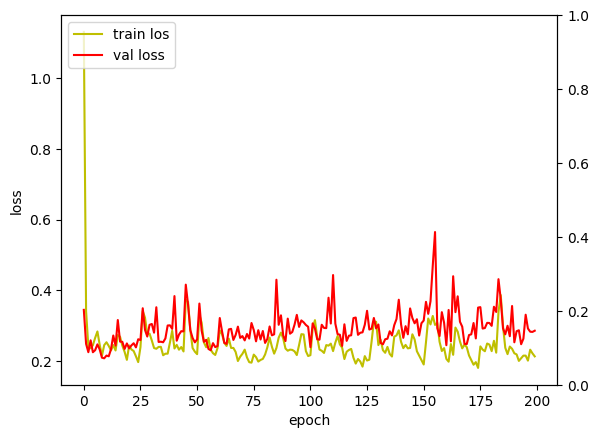

In [96]:
graph_val_train(hist)

In [97]:
model_8 = makeDNN()

hist2 = model_8.fit(X_train_t, y_train_t,
                     validation_data=(X_val, y_val),
                        epochs=10, batch_size=10)

Epoch 1/10
20/20 [==============================] - 2s 18ms/step - loss: 1.1373 - accuracy: 0.9010 - val_loss: 0.3657 - val_accuracy: 0.9583
Epoch 2/10
20/20 [==============================] - 0s 4ms/step - loss: 0.3419 - accuracy: 0.9479 - val_loss: 0.2567 - val_accuracy: 0.9583
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.2372 - accuracy: 0.9479 - val_loss: 0.2287 - val_accuracy: 0.9583
Epoch 4/10
20/20 [==============================] - 0s 4ms/step - loss: 0.2370 - accuracy: 0.9479 - val_loss: 0.2623 - val_accuracy: 0.9583
Epoch 5/10
20/20 [==============================] - 0s 4ms/step - loss: 0.2441 - accuracy: 0.9479 - val_loss: 0.2284 - val_accuracy: 0.9583
Epoch 6/10
20/20 [==============================] - 0s 4ms/step - loss: 0.2929 - accuracy: 0.9479 - val_loss: 0.2795 - val_accuracy: 0.9583
Epoch 7/10
20/20 [==============================] - 0s 5ms/step - loss: 0.3407 - accuracy: 0.9479 - val_loss: 0.2839 - val_accuracy: 0.9583
Epoch 8/10
20/20 [=

In [98]:
test_loss2, test_acc2 = model_8.evaluate(X_test5, y_test5)

print("Test accuracy:", round(test_acc2,3))

2/2 [==============================] - 0s 4ms/step - loss: 0.2248 - accuracy: 0.9508
Test accuracy: 0.951


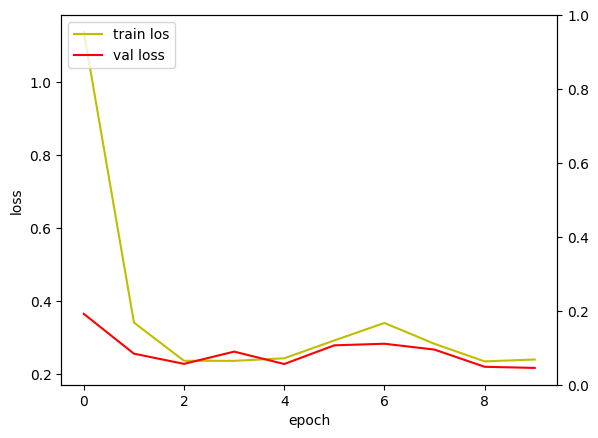

In [99]:
graph_val_train(hist2)

https://3months.tistory.com/321  
https://datahacker.rs/018-pytorch-popular-techniques-to-prevent-the-overfitting-in-a-neural-networks/  

# 병원 정보 api 불러오기

In [ ]:
serviceKey = "repbMvjCXw96iTs6wjKM3Htm1H480VcdawruKmikMmOYZF8aVD/rJDkfGoyLeTuS5Y1KEOzUrwwPIu87UQ9LbQ=="
serviceKeyDecoded = parse.unquote(serviceKey, 'UTF-8')

url = "http://apis.data.go.kr/B551182/hospInfoServicev2/getHospBasisList"
returnType="xml"
Pindex = 1
Psize = 1000


queryParams = '?' + parse.urlencode({ parse.quote_plus("serviceKey") : serviceKeyDecoded,
                                parse.quote_plus("numOfRows") : '10000',
                                parse.quote_plus("pageNo") : '2'
                                    })

res = requests.get(url + queryParams)

In [ ]:
soup = BeautifulSoup(res.text, 'lxml-xml')
items = soup.find_all("item")

In [ ]:
pprint.pprint(items)

In [ ]:
len(items)

In [ ]:
def parse():
    try:
        ADDR = item.find("addr").get_text()
        CLCD = item.find("clCd").get_text()
        CLCDNM = item.find("clCdNm").get_text()
        EMDONGNM = item.find("emdongNm").get_text()
        ESTBDB = item.find("estbDd").get_text()
        POSTNO = item.find("postNo").get_text()
        SGGUCD = item.find("sgguCd").get_text()
        SGGUCDNM = item.find("sgguCdNm").get_text()
        SIDOCD = item.find("sidoCd").get_text()
        SIDOCDNM = item.find("sidoCdNm").get_text()
        XPOS = item.find("XPos").get_text()
        YPOS = item.find("YPos").get_text()
        YADMNM = item.find("yadmNm").get_text()
        YKIHO = item.find("ykiho").get_text()
        return {
            "주소":ADDR,
            "종별코드":CLCD,
            "종별코드명":CLCDNM,
            "읍면동":EMDONGNM,
            "개설일자":ESTBDB,
            "Post No.":POSTNO,
            "시군구코드":SGGUCD,
            "시군구코드명":SGGUCDNM,
            "시도코드":SIDOCD,
            "시도코드명":SIDOCDNM,
            "x좌표":XPOS,
            'y좌표':YPOS,
            "요양기관명":YADMNM,
            "암호화요양기호":YKIHO
        }
    except AttributeError as e:
        return {
            "주소":None,
            "종별코드":None,
            "종별코드명":None,
            "읍면동":None,
            "개설일자":None,
            "Post No.":None,
            "시군구코드":None,
            "시군구코드명":None,
            "시도코드":None,
            "시도코드명":None,
            "x좌표":None,
            'y좌표':None,
            "요양기관명":None,
            "암호화요양기호":None
        }

In [ ]:
row = list()

for item in items : 
    row.append(parse())

In [ ]:
df_api = pd.DataFrame(row)
df_api.head()

In [ ]:
df_api.shape[0] - df_api.count()

In [ ]:
df_api.dropna(axis=0, how="any", inplace=True)
df_api.shape

In [ ]:
df_api.to_csv(dirShare+"/data/병원정보api_day2.csv",sep=',', encoding="utf-8")

In [ ]:
# 17년도 당기순이익 히스토그램
sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="profit1", Range=12)

In [ ]:
#17년도 당기순이익 박스플롯
sp_boxplot(DF=df_join_clst, colClst="NumberOfCluster", colbox="profit1", Range=10)

In [ ]:
# test_df[test_df["1"].notnull()]

In [ ]:
# 16년도 당기순이익
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="profit2")

In [ ]:
# 17년도 이익 잉여금
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="surplus1")

In [ ]:
# 16년도 이익 잉여금
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="surplus2")

In [ ]:
# 17년도 직원수
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="employee1")

In [ ]:
# 16년도 직원수
# sp_hist(DF=df_join_clst, colClst="NumberOfCluster", colhist="employee2")